In [1]:
#!conda env list

In [2]:
#!conda run -p /home/njm12/ATMS_523/envs/xarray-climate python -m ipykernel install --user --name xarray-climate --display-name "Python (xarray-climate)"

In [3]:
import sys
print(sys.executable)

/home/njm12/ATMS_523/envs/xarray-climate/bin/python


In [4]:
# Cell 1: Imports and environment setup
import os
import glob
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, Point, box
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import matplotlib.patches as patches
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
from shapely.ops import nearest_points
from geopy.distance import geodesic

#Interactive Tool Imports
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook"  # or "notebook_connected"

#Statistical Significance Testing Imports
from scipy.stats import kruskal
import itertools

# Allow OGR to accept non-closed rings
os.environ["OGR_GEOMETRY_ACCEPT_UNCLOSED_RING"] = "YES"

# --- Configuration ---
base_dir = "/home/njm12/ATMS_596/Land-Water"
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_csv = "/home/njm12/ATMS_596/1950-2024_actual_tornadoes.csv"  # Update with your CSV path
states_of_interest = ["IL", "IA", "MO"]
min_date = pd.to_datetime("1950-01-01")  # Start from first date in dataset

In [5]:
# Cell 2: Load UMESC Mississippi River shapefiles
pool_dirs = [f"Pool {p}" for p in range(12, 27) if p != 23] + ["Open River", "Open River 2"]
gdfs = []

for pool_dir in pool_dirs:
    if "Open River" in pool_dir:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z16n83.shp"))
        local_crs = "EPSG:26916"
    else:
        shp_files = glob.glob(os.path.join(base_dir, pool_dir, "*z15n83.shp"))
        local_crs = target_crs

    for f in shp_files:
        gdf = gpd.read_file(f)
        if gdf.crs is None:
            gdf = gdf.set_crs(local_crs)
        gdf = gdf.to_crs(target_crs)
        gdf["POOL"] = pool_dir
        gdfs.append(gdf)

umesc_all = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=target_crs)
print("UMESC combined:", umesc_all.shape)
print(f"Pools included: {sorted(umesc_all['POOL'].unique())}")

ERROR 1: PROJ: proj_create_from_database: Open of /home/njm12/ATMS_523/envs/xarray-climate/share/proj failed


UMESC combined: (8050, 14)
Pools included: ['Open River', 'Open River 2', 'Pool 12', 'Pool 13', 'Pool 14', 'Pool 15', 'Pool 16', 'Pool 17', 'Pool 18', 'Pool 19', 'Pool 20', 'Pool 21', 'Pool 22', 'Pool 24', 'Pool 25', 'Pool 26']


In [6]:
# --- Derive approximate river centerline from UMESC polygons ---
# Fix invalid polygons before union
umesc_all["geometry"] = umesc_all.geometry.make_valid()
umesc_all["geometry"] = umesc_all.buffer(0)  # Ensures clean geometry

# Use the new 'union_all()' method (replaces deprecated unary_union)
river_union = umesc_all.union_all()

# Derive approximate river centerline
river_centerline = gpd.GeoSeries([river_union], crs=target_crs).buffer(-200).boundary
river_centerline = gpd.GeoDataFrame(geometry=river_centerline, crs=target_crs)
print("River centerline constructed from UMESC polygons.")

River centerline constructed from UMESC polygons.


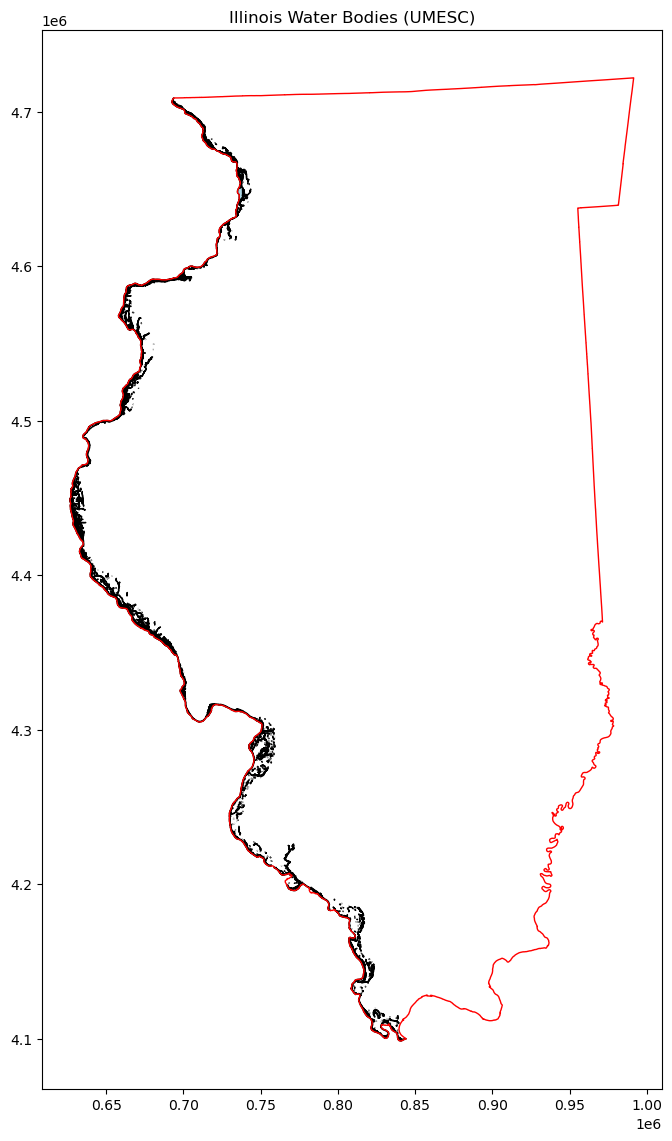

In [7]:
# Cell 3: Extract Illinois water portion
url = "https://www2.census.gov/geo/tiger/TIGER2023/STATE/tl_2023_us_state.zip"
states = gpd.read_file(url)
illinois = states[states["NAME"] == "Illinois"].to_crs(target_crs)

# Filter water polygons only
water_only = umesc_all[umesc_all["LAND_WATER"] == "Water"].copy()
water_il = gpd.clip(water_only, illinois)

# Plot check
ax = water_il.plot(figsize=(8, 14), color="lightblue", edgecolor="k")
illinois.boundary.plot(ax=ax, color="red", linewidth=1)
ax.set_title("Illinois Water Bodies (UMESC)")
plt.show()

In [8]:
print("Number of invalid geometries in water_only:", (~water_only.is_valid).sum())
print("Invalid geometries indices:", water_only[~water_only.is_valid].index)

Number of invalid geometries in water_only: 0
Invalid geometries indices: Index([], dtype='int64')


In [9]:
# Fix invalid geometries using buffer(0) - only if needed
water_only.loc[~water_only.is_valid, "geometry"] = water_only.loc[~water_only.is_valid, "geometry"].buffer(0)

# Verify
print("Invalid geometries after fix:", (~water_only.is_valid).sum())

Invalid geometries after fix: 0


In [10]:
# Ensure Illinois geometry is valid
illinois["geometry"] = illinois["geometry"].buffer(0)

# Perform clip
water_il = gpd.clip(water_only, illinois)

print("Clipped water shapes:", water_il.shape)

Clipped water shapes: (2876, 14)


In [11]:
# Combine all Illinois water polygons into a single geometry
river_il = water_il.union_all()
print(type(river_il))
print("Bounds of Illinois river section:", river_il.bounds)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
Bounds of Illinois river section: (626594.3664122473, 4098437.22724262, 844182.0029604747, 4708927.272888837)


In [12]:
# Automatic date parsing
tornadoes = pd.read_csv(tornado_csv, parse_dates=['date'])

# Filter by states, EF-scale, and date (can include stronger tornadoes on map, if necessary / min_date will likely be changed)
tornadoes = tornadoes[
    tornadoes['st'].isin(states_of_interest) &
    tornadoes['mag'].isin([0, 1, 2, 3, 4, 5]) &
    (tornadoes['date'] >= min_date)
]

print("Filtered tornadoes:", tornadoes.shape)
tornadoes

Filtered tornadoes: (8287, 29)


,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
6,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,...,18.80,50,1,1,1,119,117,0,0,0
7,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,...,18.00,200,1,1,1,119,5,0,0,0
9,201,1950,12,2,1950-12-02,17:30:00,3,IL,17,9,...,9.60,50,1,1,1,157,0,0,0,0
11,5,1950,1,25,1950-01-25,19:30:00,3,MO,29,2,...,2.30,300,1,1,1,93,0,0,0,0
12,6,1950,1,25,1950-01-25,21:00:00,3,IL,17,3,...,0.10,100,1,1,1,91,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71664,624857,2024,8,15,2024-08-15,22:06:00,3,IL,17,0,...,3.20,50,1,1,1,175,0,0,0,0
71687,624880,2024,8,30,2024-08-30,11:45:00,3,IL,17,0,...,0.08,20,1,1,1,157,0,0,0,0
71712,624820,2024,8,5,2024-08-05,20:57:00,3,IA,19,0,...,0.33,30,1,1,1,191,0,0,0,0
71713,624821,2024,8,5,2024-08-05,21:11:00,3,IA,19,0,...,0.98,80,1,1,1,191,0,0,0,0


In [13]:
# Remove any rows with missing or invalid coordinates
coord_cols = ['slon', 'slat', 'elon', 'elat']
tornadoes = tornadoes.dropna(subset=coord_cols)

# Remove out-of-bounds or unrealistic coordinates
tornadoes = tornadoes[
    (tornadoes['slon'].between(-180, 180)) &
    (tornadoes['elon'].between(-180, 180)) &
    (tornadoes['slat'].between(-90, 90)) &
    (tornadoes['elat'].between(-90, 90))
]
print("After coordinate cleaning:", tornadoes.shape)

After coordinate cleaning: (8287, 29)


In [14]:
# --- Fix 1: Convert positive longitudes (U.S. longitudes are negative west of Greenwich) ---
tornadoes['slon'] = tornadoes['slon'].apply(lambda x: -x if x > 0 else x)
tornadoes['elon'] = tornadoes['elon'].apply(lambda x: -x if x > 0 else x)

# --- Fix 2: Remove zero or missing coordinates (invalid positions) ---
tornadoes.loc[tornadoes['slat'] == 0, 'slat'] = np.nan
tornadoes.loc[tornadoes['elat'] == 0, 'elat'] = np.nan
tornadoes.loc[tornadoes['slon'] == 0, 'slon'] = np.nan
tornadoes.loc[tornadoes['elon'] == 0, 'elon'] = np.nan

# Drop rows with NaNs after cleaning
tornadoes = tornadoes.dropna(subset=['slon', 'slat', 'elon', 'elat']).copy()

# Check coordinate ranges again
print("Longitude range (fixed):", tornadoes[['slon', 'elon']].min().min(), "to", tornadoes[['slon', 'elon']].max().max())
print("Latitude range (fixed):", tornadoes[['slat', 'elat']].min().min(), "to", tornadoes[['slat', 'elat']].max().max())

Longitude range (fixed): -96.6 to -85.23
Latitude range (fixed): 36.0022 to 45.5


In [15]:
from shapely.geometry import LineString, Point
import geopandas as gpd

# Create LineString or Point geometries
def make_geom(row):
    if pd.isna(row['elon']) or pd.isna(row['elat']) or \
       (row['elon'] == row['slon'] and row['elat'] == row['slat']):
        return Point(row['slon'], row['slat'])
    else:
        return LineString([(row['slon'], row['slat']), (row['elon'], row['elat'])])

tornadoes['geometry'] = tornadoes.apply(make_geom, axis=1)

# Convert to GeoDataFrame
tornado_gdf = gpd.GeoDataFrame(tornadoes, geometry='geometry', crs="EPSG:4326")

# Reproject to match water shapefile CRS
tornado_gdf = tornado_gdf.to_crs(target_crs)

print("Tornado geometries rebuilt")
print("Geometry types:", tornado_gdf.geometry.geom_type.value_counts())
print("Bounds:", tornado_gdf.total_bounds)

Tornado geometries rebuilt
Geometry types: LineString    4739
Point         1054
Name: count, dtype: int64
Bounds: [ 205367.62901075 3987738.95756939 1160467.39964418 5041734.47457036]


In [16]:
# Fix invalid water polygons
water_il['geometry'] = water_il['geometry'].buffer(0)

# Merge into single geometry
river_il_geom = water_il.geometry.union_all()  # or .union_all() if using new shapely

# Ensure the final geometry is valid
from shapely.validation import make_valid
river_il_geom = make_valid(river_il_geom)

In [17]:
# Buffer by 10 km
river_buffer = river_il_geom.buffer(10000)  # adjust as needed

# Check intersections with buffer
tornado_gdf['crosses_river'] = tornado_gdf.intersects(river_buffer)
crossings = tornado_gdf[tornado_gdf['crosses_river']]

print("Total tornadoes crossing Mississippi River or intersecting buffered zone:", crossings.shape[0])
print("Counts by EF-scale:\n", crossings['mag'].value_counts())

Total tornadoes crossing Mississippi River or intersecting buffered zone: 372
Counts by EF-scale:
 mag
0    124
1    122
2     79
3     37
4     10
Name: count, dtype: int64


In [18]:
#Quick sanity to make sure the river buffer is actually or approximately ~10 km (and in the right units). 

from shapely.ops import nearest_points

# Pick a point on the river geometry
river_point = river_il_geom.representative_point()

# Pick nearest point on the buffer boundary
buffer_boundary = river_buffer.boundary
nearest = nearest_points(river_point, buffer_boundary)[1]

# Compute distance in meters (UTM units)
distance_m = river_point.distance(nearest)
distance_km = distance_m / 1000
print(f"Distance from river to buffer boundary: {distance_km:.2f} km")

Distance from river to buffer boundary: 10.67 km


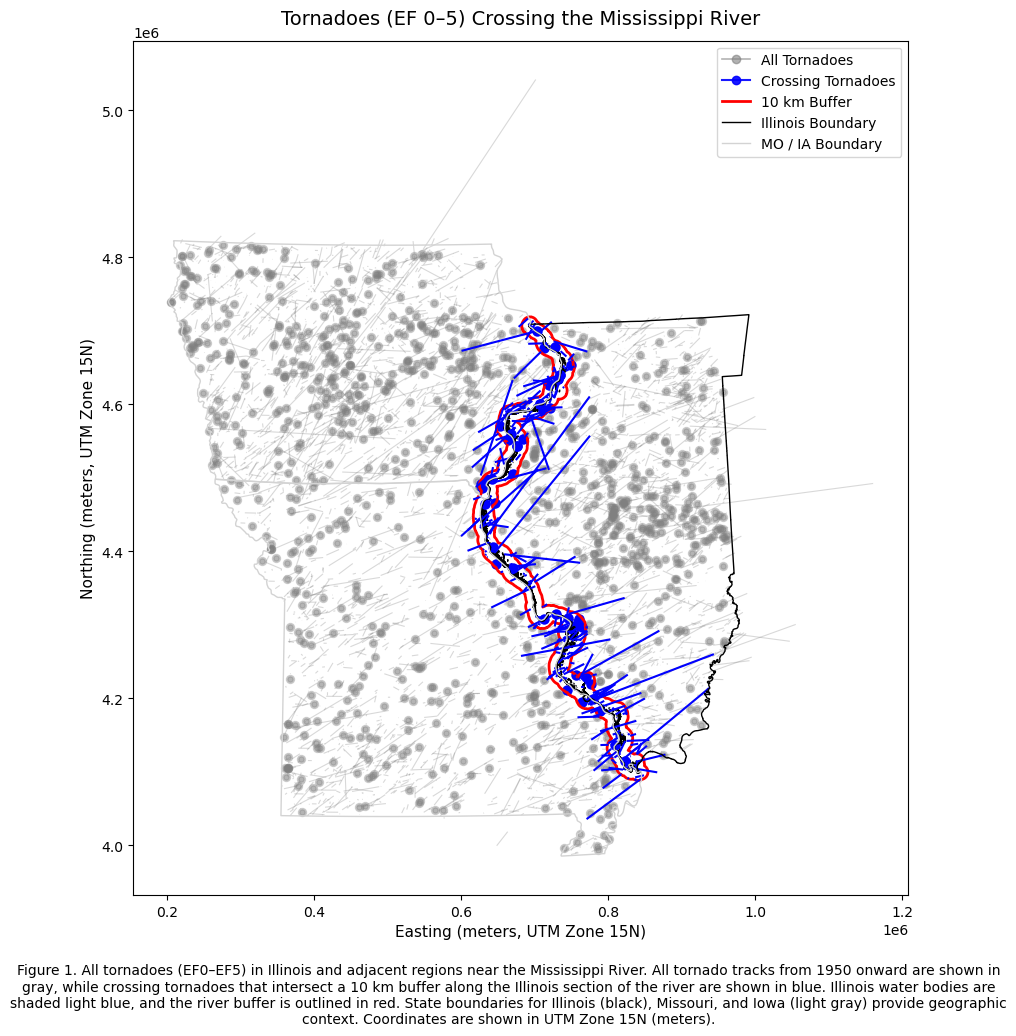

In [19]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# --- Step 5: Plot ---
fig, ax = plt.subplots(figsize=(10, 14))

# Plot Illinois water and river buffer
water_il.plot(ax=ax, color='lightblue', edgecolor='k')
gpd.GeoSeries([river_buffer]).boundary.plot(ax=ax, color='red', linewidth=2, label='10 km Buffer')

# Plot all tornadoes (lines + points)
tornado_gdf.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3)
tornado_gdf[tornado_gdf.geometry.geom_type == 'Point'].plot(ax=ax, color='gray', markersize=15, alpha=0.4)

# Plot crossing tornadoes (lines + points)
crossings.plot(ax=ax, color='blue', linewidth=1.5)
crossings[crossings.geometry.geom_type == 'Point'].plot(ax=ax, color='blue', markersize=25)

# Plot Illinois, Missouri, and Iowa boundaries
illinois.boundary.plot(ax=ax, color='black', linewidth=1, label='Illinois Boundary')

states_path = "/home/njm12/ATMS_596/ne_10m_admin_1_states_provinces.shp"
states = gpd.read_file(states_path).to_crs(target_crs)
states_mo_ia = states[states['name'].isin(['Missouri', 'Iowa'])]
states_mo_ia.boundary.plot(ax=ax, color='lightgray', linewidth=1, label='MO / IA Boundary')

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# --- Labels, title, and caption ---
ax.legend(handles=legend_elements, loc='upper right')
ax.set_title("Tornadoes (EF 0–5) Crossing the Mississippi River", fontsize=14, pad=12)
ax.set_xlabel("Easting (meters, UTM Zone 15N)", fontsize=11)
ax.set_ylabel("Northing (meters, UTM Zone 15N)", fontsize=11)

# Figure caption
caption = (
    "Figure 1. All tornadoes (EF0–EF5) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 1950 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in UTM Zone 15N (meters)."
)
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

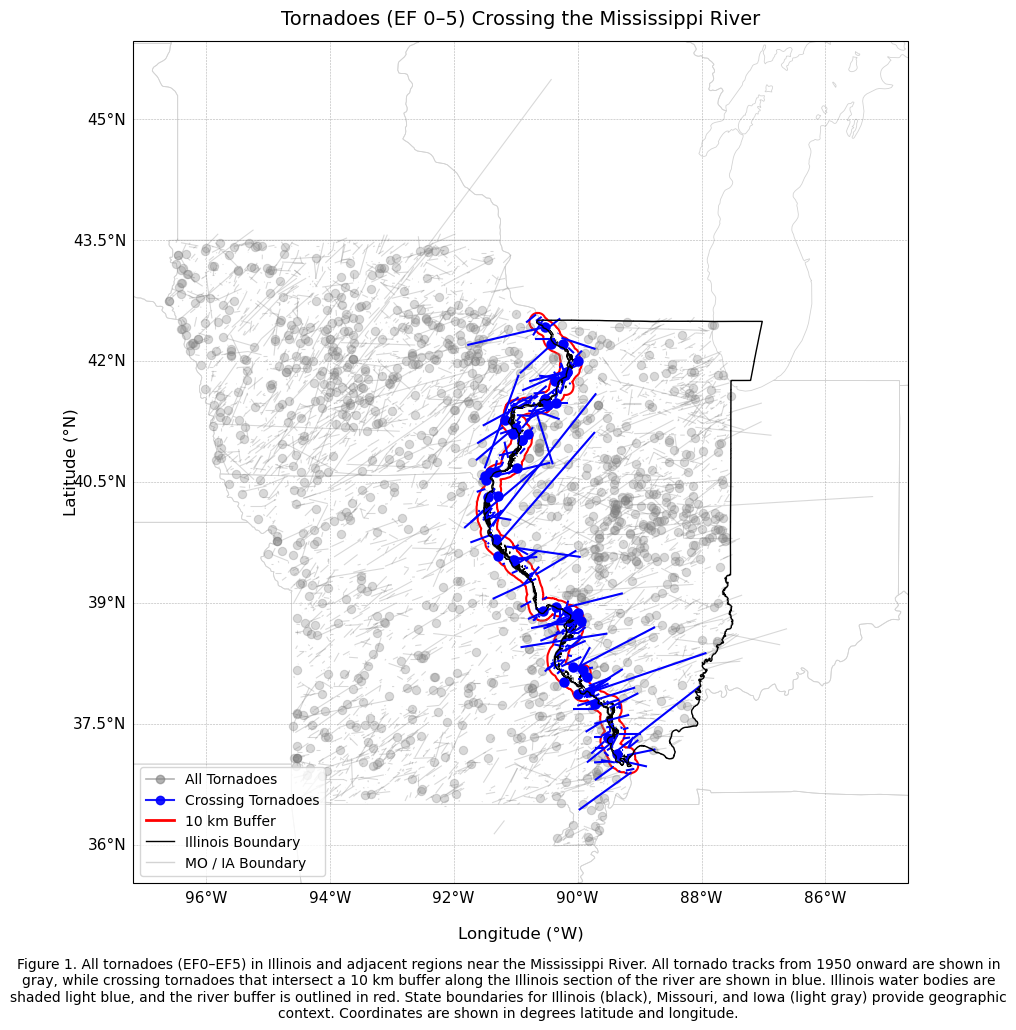

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = tornado_gdf.to_crs("EPSG:4326")
crossings_geo = crossings.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([river_buffer], crs=water_il.crs).to_crs("EPSG:4326")

# --- Plot ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Add map background
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# Plot layers
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)
tornado_geo.plot(ax=ax, color='gray', linewidth=0.8, alpha=0.3, transform=ccrs.PlateCarree(), label='All Tornadoes', zorder=3)
crossings_geo.plot(ax=ax, color='blue', linewidth=1.5, transform=ccrs.PlateCarree(), label='Crossing Tornadoes', zorder=4)
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# Gridlines and coordinate labels
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

# Add axis labels manually
ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- Custom legend handles (combined line + point) ---
legend_elements = [
    Line2D([0], [0], color='gray', linewidth=1.2, marker='o', markersize=6, 
           label='All Tornadoes', alpha=0.6),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, 
           label='Crossing Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
    Line2D([0], [0], color='lightgray', linewidth=1, label='MO / IA Boundary'),
]

# Add title and legend
ax.set_title("Tornadoes (EF 0–5) Crossing the Mississippi River", fontsize=14, pad=12)
ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)

# Caption
caption = (
    "Figure 1. All tornadoes (EF0–EF5) in Illinois and adjacent regions near the Mississippi River. "
    "All tornado tracks from 1950 onward are shown in gray, while crossing tornadoes that intersect a 10 km buffer "
    "along the Illinois section of the river are shown in blue. Illinois water bodies are shaded light blue, "
    "and the river buffer is outlined in red. State boundaries for Illinois (black), Missouri, and Iowa (light gray) "
    "provide geographic context. Coordinates are shown in degrees latitude and longitude."
)
plt.figtext(0.5, 0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

In [21]:
# -------------------------------------------------------------------
# --- Identify west-side, east-side, and crossing tornadoes ---
# -------------------------------------------------------------------

# 1. Start with weak tornadoes only (EF 0–2)
weak_tornadoes = tornado_gdf[tornado_gdf["mag"].isin([0, 1, 2, 3, 4, 5])].copy()

# 2. Tornadoes that cross/touch the river (same as before)
crossing_tornadoes = weak_tornadoes[weak_tornadoes.intersects(river_il_geom)]

# 3. Tornadoes that are within or touch the 10 km buffer but do NOT touch/cross the river
buffer_only = weak_tornadoes[
    weak_tornadoes.intersects(river_buffer) & 
    (~weak_tornadoes.intersects(river_il_geom))
].copy()

# 4. Compute centroid of each tornado track for side determination
buffer_only["centroid"] = buffer_only.geometry.centroid

# 5. Determine whether centroids are west or east of the river
#    We'll use the river's centroid X-coordinate as an approximate divider
river_center_x = river_il_geom.centroid.x

west_side = buffer_only[buffer_only["centroid"].x < river_center_x]
east_side = buffer_only[buffer_only["centroid"].x >= river_center_x]

# 6. Print summary results
print("\n--- Tornado Interaction Summary ---")
print(f"Total tornadoes: {len(weak_tornadoes)}")
print(f"  • West-side (within/touching 10 km buffer, not touching river): {len(west_side)}")
print(f"  • East-side (within/touching 10 km buffer, not touching river): {len(east_side)}")
print(f"  • Crossing/touching the river: {len(crossing_tornadoes)}")
print(f"  • Sum check: {len(west_side) + len(east_side) + len(crossing_tornadoes)} (should equal 372)")


--- Tornado Interaction Summary ---
Total tornadoes: 5793
  • West-side (within/touching 10 km buffer, not touching river): 120
  • East-side (within/touching 10 km buffer, not touching river): 163
  • Crossing/touching the river: 89
  • Sum check: 372 (should equal 372)


In [22]:
# ---------- Robust classification into West Control / East Control / Test (buffer/river) ----------
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Make sure we use the variable names you have defined earlier:
# tornado_gdf  (all tornadoes, already reprojected to target_crs)
# weak_tornadoes (subset of tornado_gdf with mag in [0,1,2])
# river_il_geom  (shapely geometry of Illinois river section)
# river_buffer   (10 km buffer around river_il_geom) -- can be shapely geometry or GeoSeries

# 0) Ensure consistent CRS on weak_tornadoes
weak_tornadoes = weak_tornadoes.to_crs(target_crs)

# 1) Ensure buffer is a single (unary) shapely geometry for intersections
# If river_buffer is a GeoSeries or GeoDataFrame, get the unary_union (or .iloc[0] if single)
try:
    buffer_union = river_buffer
    # if it's a GeoSeries/GeoDataFrame convert to unary_union
    if hasattr(buffer_union, "unary_union"):
        buffer_union = buffer_union.unary_union
except NameError:
    # If river_buffer not available, create from river_il_geom
    buffer_union = river_il_geom.buffer(10000).union()

In [23]:
# 2) Test population: any weak tornado that intersects/touches the buffer OR intersects the river polygon itself
#    (this includes crossings which intersect the river geometry)
test_mask = weak_tornadoes.geometry.intersects(buffer_union) | weak_tornadoes.geometry.intersects(river_il_geom)
test_population = weak_tornadoes[test_mask].copy()

In [24]:
# 3) Outside buffer: those that do NOT intersect the buffer
# Compute side relative to actual river geometry
outside_buffer = weak_tornadoes[~test_mask].copy()

outside_buffer["centroid"] = outside_buffer.geometry.centroid

def assign_west_east(row, river_geom):
    centroid = row.centroid
    nearest = nearest_points(centroid, river_geom)[1]  # nearest point on river
    dx = centroid.x - nearest.x
    return "West Control" if dx < 0 else "East Control"

outside_buffer["side_type"] = outside_buffer.apply(assign_west_east, axis=1, river_geom=river_il_geom)

# Reassign west_control and east_control
west_control = outside_buffer[outside_buffer["side_type"] == "West Control"].copy()
east_control = outside_buffer[outside_buffer["side_type"] == "East Control"].copy()

#Before: split by centroid_x vs a single river_center_x -> vertical line.
#After: split by relative position to nearest river point -> follows meandering river.

In [25]:
# 7) Verify counts and find any unclassified (should not happen, but check)
combined_idx = test_population.index.union(west_control.index).union(east_control.index)
unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
print("Initial sizes:")
print(f"  Test population (intersect buffer/river): {len(test_population)}")
print(f"  West control (outside buffer):            {len(west_control)}")
print(f"  East control (outside buffer):            {len(east_control)}")
print(f"  Unclassified (should be 0):               {len(unclassified)}")
print(f"  Sum categories:                           {len(test_population)+len(west_control)+len(east_control)}")
print(f"  Total tornadoes:                          {len(weak_tornadoes)}")

Initial sizes:
  Test population (intersect buffer/river): 372
  West control (outside buffer):            3554
  East control (outside buffer):            1867
  Unclassified (should be 0):               0
  Sum categories:                           5793
  Total tornadoes:                          5793


In [26]:
# 8) If any unclassified exist (tiny rounding artifacts), assign them deterministically:
if len(unclassified) > 0:
    # compute centroid x for those too
    unclassified["centroid"] = unclassified.geometry.centroid
    unclassified["centroid_x"] = unclassified["centroid"].apply(lambda p: p.x)
    # assign by centroid_x
    assign_west = unclassified[unclassified["centroid_x"] < river_center_x].index
    assign_east = unclassified[unclassified["centroid_x"] >= river_center_x].index
    west_control = pd.concat([west_control, unclassified.loc[assign_west]])
    east_control = pd.concat([east_control, unclassified.loc[assign_east]])
    # recompute combined check
    combined_idx = test_population.index.union(west_control.index).union(east_control.index)
    unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
    print("After deterministic centroid assignment, remaining unclassified:", len(unclassified))
    # If still unclassified (very unlikely), assign by nearest distance to river centerline
    if len(unclassified) > 0:
        # build a river centerline (if you have river_centerline GeoSeries earlier use that)
        try:
            centerline = river_centerline.unary_union
        except Exception:
            # fallback: approximate centerline by taking river_il_geom.representative_point()
            centerline = river_il_geom.representative_point()
        # compute distance to centerline and assign west/east by centroid_x anyway
        for idx, row in unclassified.iterrows():
            cx = row.geometry.centroid.x
            if cx < river_center_x:
                west_control = pd.concat([west_control, row.to_frame().T])
            else:
                east_control = pd.concat([east_control, row.to_frame().T])
        
# final check
combined_idx = test_population.index.union(west_control.index).union(east_control.index)
unclassified = weak_tornadoes[~weak_tornadoes.index.isin(combined_idx)].copy()
print("After fallback nearest assignment, remaining unclassified:", len(unclassified))

After fallback nearest assignment, remaining unclassified: 0


In [27]:
# 9) Final assert / sanity check
total_calc = len(test_population) + len(west_control) + len(east_control)
print("\nFinal totals check:")
print(f"  Sum categories = {total_calc}")
print(f"  Total tornadoes = {len(weak_tornadoes)}")
assert total_calc == len(weak_tornadoes), "Final counts DO NOT sum to total tornadoes!"


Final totals check:
  Sum categories = 5793
  Total tornadoes = 5793


In [28]:
# 10) Create breakdown table for EF 0/1/2/3/4/5
def mag_counts(df):
    # Ensure mag is int-like and EF 0/1/2/3/4/5
    s = df["mag"].astype(int).value_counts().reindex([0, 1, 2, 3, 4, 5], fill_value=0)
    return s.to_dict()

summary = pd.DataFrame({
    "Category": ["West Control", "East Control", "Test (Buffer/River)"],
    "Count": [len(west_control), len(east_control), len(test_population)],
    "EF0": [mag_counts(west_control)[0], mag_counts(east_control)[0], mag_counts(test_population)[0]],
    "EF1": [mag_counts(west_control)[1], mag_counts(east_control)[1], mag_counts(test_population)[1]],
    "EF2": [mag_counts(west_control)[2], mag_counts(east_control)[2], mag_counts(test_population)[2]],
    "EF3": [mag_counts(west_control)[3], mag_counts(east_control)[3], mag_counts(test_population)[3]],
    "EF4": [mag_counts(west_control)[4], mag_counts(east_control)[4], mag_counts(test_population)[4]],
    "EF5": [mag_counts(west_control)[5], mag_counts(east_control)[5], mag_counts(test_population)[5]],
})

summary["Total EF0–EF5"] = summary[["EF0", "EF1", "EF2", "EF3", "EF4", "EF5"]].sum(axis=1)

# Add totals row
totals = summary[["Count", "EF0", "EF1", "EF2", "EF3", "EF4", "EF5", "Total EF0–EF5"]].sum()
totals_row = pd.DataFrame([["All Tornadoes", totals["Count"], int(totals["EF0"]), int(totals["EF1"]), int(totals["EF2"]), int(totals["EF3"]), int(totals["EF4"]), int(totals["EF5"]), int(totals["Total EF0–EF5"])]],
                          columns=summary.columns)
summary = pd.concat([summary, totals_row], ignore_index=True)

print("\n--- Tornado Populations Summary ---")
print(summary.to_string(index=False))


--- Tornado Populations Summary ---
           Category  Count  EF0  EF1  EF2  EF3  EF4  EF5  Total EF0–EF5
       West Control   3554 1561 1158  588  176   65    6           3554
       East Control   1867  885  628  242   84   26    2           1867
Test (Buffer/River)    372  124  122   79   37   10    0            372
      All Tornadoes   5793 2570 1908  909  297  101    8           5793


In [29]:
# --- 1. Prepare data ---
# Add side_type column for clarity
weak_tornadoes["side_type"] = "Unclassified"
weak_tornadoes.loc[weak_tornadoes.index.isin(west_control.index), "side_type"] = "West Control"
weak_tornadoes.loc[weak_tornadoes.index.isin(east_control.index), "side_type"] = "East Control"
weak_tornadoes.loc[weak_tornadoes.index.isin(test_population.index), "side_type"] = "Test (Buffer/River)"

# Reproject all layers to geographic (EPSG:4326)
tornado_geo = weak_tornadoes.to_crs("EPSG:4326")
water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([buffer_union], crs=water_il.crs).to_crs("EPSG:4326")

# Split tornadoes by category for plotting
west_geo = tornado_geo[tornado_geo["side_type"] == "West Control"]
east_geo = tornado_geo[tornado_geo["side_type"] == "East Control"]
test_geo = tornado_geo[tornado_geo["side_type"] == "Test (Buffer/River)"]

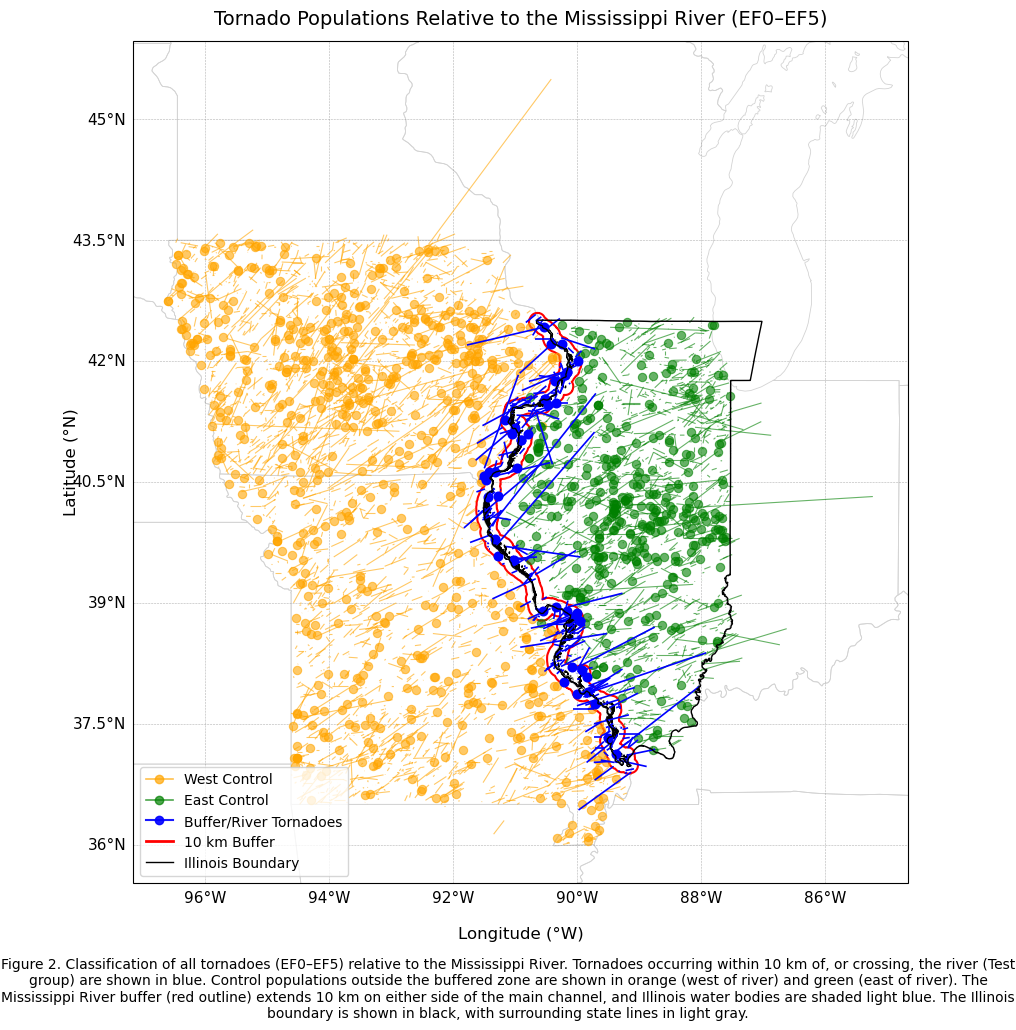

In [30]:
# --- 2. Plot setup ---
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Background features
ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor='lightgray', linewidth=0.6)

# --- 3. Plot data layers ---
# Base river and buffer
water_il_geo.plot(ax=ax, color='lightblue', edgecolor='k', transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color='red', linewidth=1.5, transform=ccrs.PlateCarree(), label='10 km Buffer', zorder=2)

# Tornado groups
west_geo.plot(ax=ax, color='orange', linewidth=0.8, alpha=0.6, transform=ccrs.PlateCarree(), label='West Control', zorder=3)
east_geo.plot(ax=ax, color='green', linewidth=0.8, alpha=0.6, transform=ccrs.PlateCarree(), label='East Control', zorder=3)
test_geo.plot(ax=ax, color='blue', linewidth=1.2, transform=ccrs.PlateCarree(), label='Buffer/River Tornadoes', zorder=4)

# State boundaries
illinois_geo.boundary.plot(ax=ax, color='black', linewidth=1, transform=ccrs.PlateCarree(), zorder=5)

# --- 4. Gridlines and labels ---
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color='gray', alpha=0.6, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': 11}
gl.ylabel_style = {'size': 11}

ax.text(0.5, -0.06, 'Longitude (°W)', va='center', ha='center', fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, 'Latitude (°N)', va='center', ha='center', rotation='vertical', fontsize=12, transform=ax.transAxes)

# --- 5. Custom legend ---
legend_elements = [
    Line2D([0], [0], color='orange', linewidth=1.2, marker='o', markersize=6, label='West Control', alpha=0.7),
    Line2D([0], [0], color='green', linewidth=1.2, marker='o', markersize=6, label='East Control', alpha=0.7),
    Line2D([0], [0], color='blue', linewidth=1.5, marker='o', markersize=6, label='Buffer/River Tornadoes', alpha=0.9),
    Line2D([0], [0], color='red', linewidth=2, label='10 km Buffer'),
    Line2D([0], [0], color='black', linewidth=1, label='Illinois Boundary'),
]

ax.legend(handles=legend_elements, loc='lower left', fontsize=10, frameon=True)
ax.set_title("Tornado Populations Relative to the Mississippi River (EF0–EF5)", fontsize=14, pad=12)

# --- 6. Caption ---
caption = (
    "Figure 2. Classification of all tornadoes (EF0–EF5) relative to the Mississippi River. "
    "Tornadoes occurring within 10 km of, or crossing, the river (Test group) are shown in blue. "
    "Control populations outside the buffered zone are shown in orange (west of river) and green (east of river). "
    "The Mississippi River buffer (red outline) extends 10 km on either side of the main channel, and Illinois water "
    "bodies are shaded light blue. The Illinois boundary is shown in black, with surrounding state lines in light gray."
)
plt.figtext(0.5, 0.10, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

In [31]:
# --------------------------------------------------------------
# 1) RANDOM SAMPLING (372 each)
# --------------------------------------------------------------

# Fix seed for reproducibility
np.random.seed(42)

random_west_control = west_control.sample(n=372, replace=False, random_state=42)
random_east_control = east_control.sample(n=372, replace=False, random_state=42)

print("\n--- Random West Control Sample (372) ---")
print(random_west_control[["om", "yr", "mo", "dy", "mag", "slat", "slon", "elat", "elon"]].head(10).to_string(index=False))

print("\n--- Random East Control Sample (372) ---")
print(random_east_control[["om", "yr", "mo", "dy", "mag", "slat", "slon", "elat", "elon"]].head(10).to_string(index=False))

# --------------------------------------------------------------
# 2) REPROJECT RANDOM SUBSETS FOR PLOTTING
# --------------------------------------------------------------

random_west_geo = random_west_control.to_crs("EPSG:4326")
random_east_geo = random_east_control.to_crs("EPSG:4326")
test_geo = test_geo.to_crs("EPSG:4326")  # already defined earlier

water_il_geo = water_il.to_crs("EPSG:4326")
illinois_geo = illinois.to_crs("EPSG:4326")
river_buffer_geo = gpd.GeoSeries([buffer_union], crs=water_il.crs).to_crs("EPSG:4326")


--- Random West Control Sample (372) ---
    om   yr  mo  dy  mag    slat     slon    elat     elon
    37 1967   1  27    2 37.0200 -94.1700 37.0700 -94.1000
   152 2010   4  24    0 38.5906 -90.4392 38.5986 -90.4439
313456 2011   5  25    0 38.8369 -93.0356 38.8369 -93.0356
624288 2024   5  24    0 41.1310 -95.1000 41.1440 -95.0870
533461 2014   8  31    1 42.3072 -94.0661 42.3074 -94.0011
527459 2014   6  29    0 39.5627 -95.0526 39.5629 -95.0480
   524 2008   4  25    0 40.8500 -92.4200 40.8500 -92.4000
   499 2002   4  17    0 41.9000 -94.6800 41.9000 -94.6800
   203 2002   7  26    1 40.6800 -94.9700 40.7000 -95.0000
  1056 2009   8  19    0 43.1953 -91.8601 43.2487 -91.7849

--- Random East Control Sample (372) ---
    om   yr  mo  dy  mag    slat     slon    elat     elon
623084 2023   7  12    1 42.1544 -88.5188 42.1631 -88.3941
622118 2023   1   3    1 40.4220 -88.3670 40.4490 -88.3240
   393 2006   4  16    0 40.7500 -88.1500 40.7500 -88.1300
   233 1984   4  27    3 41.550

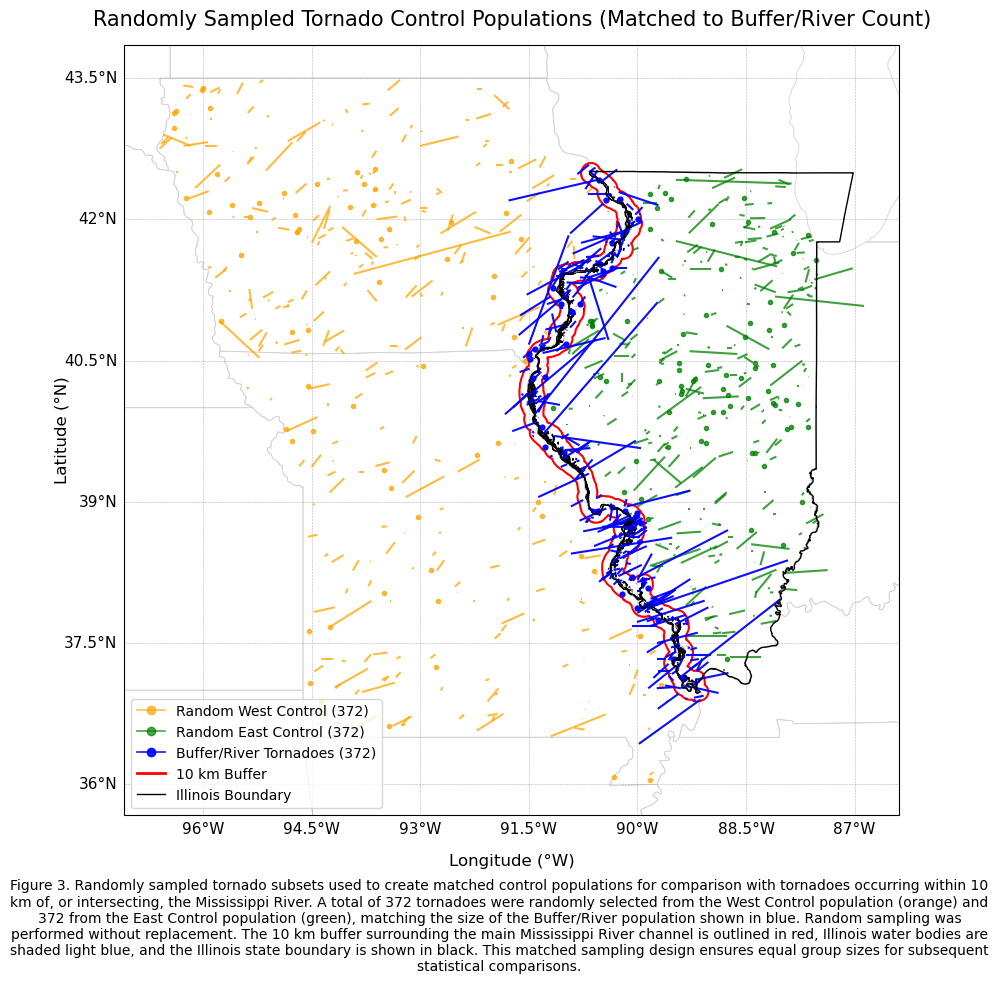

In [32]:
# --------------------------------------------------------------
# 3) PLOT THE NEW RANDOM SUBSETS
# --------------------------------------------------------------

fig, ax = plt.subplots(figsize=(10, 14), subplot_kw={'projection': ccrs.PlateCarree()})

# Background
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)
ax.add_feature(cfeature.STATES, edgecolor="lightgray", linewidth=0.6)

# Water + buffer
water_il_geo.plot(ax=ax, color="lightblue", edgecolor="k", transform=ccrs.PlateCarree(), zorder=1)
river_buffer_geo.boundary.plot(ax=ax, color="red", linewidth=1.5, transform=ccrs.PlateCarree(),
                               label="10 km Buffer", zorder=2)

# Tornado subsets (random)
random_west_geo.plot(ax=ax, color="orange", markersize=9, alpha=0.75,
                     transform=ccrs.PlateCarree(), label="Random West Control (372)", zorder=3)

random_east_geo.plot(ax=ax, color="green", markersize=9, alpha=0.75,
                     transform=ccrs.PlateCarree(), label="Random East Control (372)", zorder=3)

# Test group (full)
test_geo.plot(ax=ax, color="blue", markersize=12, alpha=0.95,
              transform=ccrs.PlateCarree(), label="Buffer/River Tornadoes (372)", zorder=4)

# Illinois boundary
illinois_geo.boundary.plot(ax=ax, color="black", linewidth=1,
                           transform=ccrs.PlateCarree(), zorder=5)

# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.4, color="gray", alpha=0.6, linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 11}
gl.ylabel_style = {"size": 11}

ax.text(0.5, -0.06, "Longitude (°W)", ha="center", va="center", fontsize=12, transform=ax.transAxes)
ax.text(-0.08, 0.5, "Latitude (°N)", ha="center", va="center", rotation="vertical",
        fontsize=12, transform=ax.transAxes)

# Legend
legend_elements = [
    Line2D([0], [0], color="orange", marker='o', lw=1.2, markersize=6,
           label="Random West Control (372)", alpha = 0.7),
    Line2D([0], [0], color="green", marker='o', lw=1.2, markersize=6,
           label="Random East Control (372)", alpha = 0.7),
    Line2D([0], [0], color="blue", marker='o', lw=1.2, markersize=6,
           label="Buffer/River Tornadoes (372)", alpha = 0.9),
    Line2D([0], [0], color="red", linewidth=2, label="10 km Buffer"),
    Line2D([0], [0], color="black", linewidth=1, label="Illinois Boundary"),
]

ax.legend(handles=legend_elements, loc="lower left", fontsize=10, frameon=True)

ax.set_title("Randomly Sampled Tornado Control Populations (Matched to Buffer/River Count)",
             fontsize=15, pad=14)

# --------------------------------------------------------------
# 4) FIGURE CAPTION
# --------------------------------------------------------------

caption = (
    "Figure 3. Randomly sampled tornado subsets used to create matched control populations for "
    "comparison with tornadoes occurring within 10 km of, or intersecting, the Mississippi River. "
    "A total of 372 tornadoes were randomly selected from the West Control population (orange) and "
    "372 from the East Control population (green), matching the size of the Buffer/River population "
    "shown in blue. Random sampling was performed without replacement. The 10 km buffer surrounding "
    "the main Mississippi River channel is outlined in red, Illinois water bodies are shaded light "
    "blue, and the Illinois state boundary is shown in black. This matched sampling design ensures "
    "equal group sizes for subsequent statistical comparisons."
)

plt.figtext(0.5, 0.11, caption, wrap=True, ha="center", fontsize=10)

plt.show()

Total tornadoes in full-population boxplot: 5793


/tmp/ipykernel_979/4203414966.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




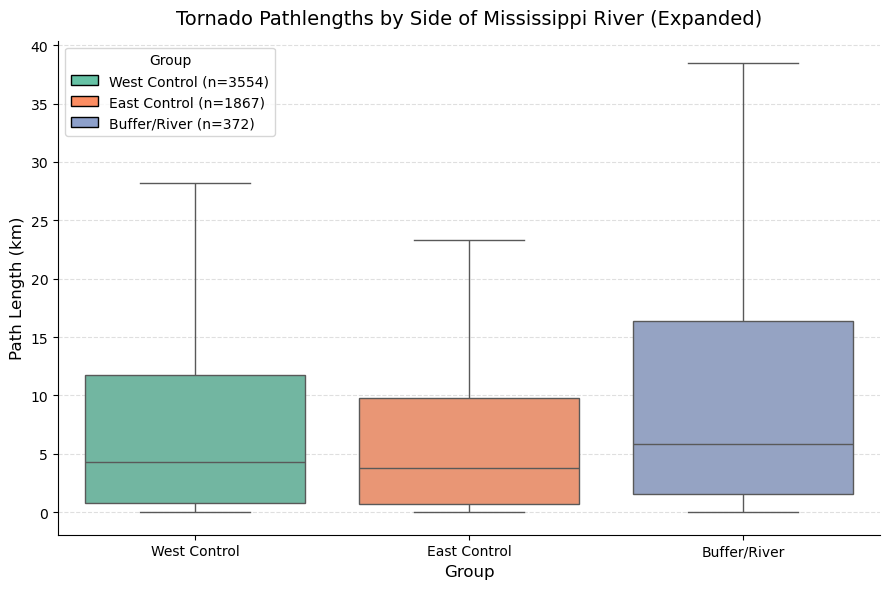


Five-number summary (km) for original populations:
              Min        Q1    Median         Q3         Max
side_type                                                   
Buffer/River  0.0  1.601293  5.825811  16.383081  237.216716
East Control  0.0  0.732250  3.765856   9.784787  252.183578
West Control  0.0  0.804670  4.345218  11.748182  260.713080


In [33]:
# --- Step 1: Prepare DataFrames for plotting ---

# Original West Control
west_full_plot = west_control[['len']].copy()
west_full_plot['side_type'] = "West Control"

# Original East Control
east_full_plot = east_control[['len']].copy()
east_full_plot['side_type'] = "East Control"

# Buffer/River (372 tornadoes)
test_plot_full = test_population[['len']].copy()
test_plot_full['side_type'] = "Buffer/River"

# --- Step 2: Convert pathlength miles → kilometers ---
for df in [west_full_plot, east_full_plot, test_plot_full]:
    df['len'] = df['len'] * 1.60934

# --- Step 3: Combine datasets ---
plot_df_full = pd.concat([west_full_plot, east_full_plot, test_plot_full], ignore_index=True)

print("Total tornadoes in full-population boxplot:", len(plot_df_full))

# --- Step 4: Create boxplot ---
plt.figure(figsize=(9, 6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=plot_df_full,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False
)

# --- Step 5: Legend with actual sample sizes ---
counts_full = plot_df_full["side_type"].value_counts()

legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{category} (n={counts_full[category]})")
    for i, category in enumerate(['West Control', 'East Control', 'Buffer/River'])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# --- Step 6: Formatting ---
ax.set_title("Tornado Pathlengths by Side of Mississippi River (Expanded)", 
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 7: Five-number summary ---
summary_stats_full = (
    plot_df_full.groupby("side_type")['len']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats_full.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary (km) for original populations:")
print(summary_stats_full)

In [34]:
# -----------------------------------------------------------
# Use full-population dataset created earlier:
# plot_df_full includes:
# - West Control
# - East Control
# - Buffer/River
# -----------------------------------------------------------

groups_full = plot_df_full.groupby('side_type')['len'].apply(list)

# Extract groups
west_len = groups_full['West Control']
east_len = groups_full['East Control']
buffer_len = groups_full['Buffer/River']

# --- 1. Overall Kruskal-Wallis test ---
stat, p = kruskal(west_len, east_len, buffer_len)

print(f"Overall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# --- 2. Pairwise tests ---
pairs = list(itertools.combinations(groups_full.index, 2))
results = []

for a, b in pairs:
    stat_ab, p_ab = kruskal(groups_full[a], groups_full[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': stat_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal-Wallis test: H = 32.289, p = 0.0000

Pairwise Kruskal-Wallis results:
         Group1        Group2          H       p-value Significant?
0  Buffer/River  East Control  28.774997  8.129384e-08          Yes
1  Buffer/River  West Control  15.488508  8.300840e-05          Yes
2  East Control  West Control  11.405656  7.322082e-04          Yes


### Kruskal-Wallis Test on Tornado Path Lengths by Side of Mississippi River (Full Populations)

**Overall Test:**
- **Kruskal–Wallis H = 32.289**, **p < 0.0001**
- **Interpretation:** There is a statistically significant difference in tornado path lengths among the three groups (West Control, East Control, Buffer/River).

**Pairwise Comparisons:**

| Group 1       | Group 2        | H         | p-value          | Significant? |
|---------------|----------------|-----------|------------------|--------------|
| Buffer/River  | East Control   | 28.775    | 8.13 × 10⁻⁸      | Yes          |
| Buffer/River  | West Control   | 15.489    | 8.30 × 10⁻⁵      | Yes          |
| East Control  | West Control   | 11.406    | 7.32 × 10⁻⁴      | Yes          |

**Summary:**
- Tornadoes in the **Buffer/River** group have **significantly different path lengths** than tornadoes on both sides of the river.
- Tornadoes on the **east and west sides** of the river also differ significantly from each other.
- Results indicate that the Mississippi River environment (or spatial configuration of tornadoes near it) is associated with distinct tornado pathlength distributions compared to the broader regional populations.

Total tornadoes included in expanded box plot: 1116


/tmp/ipykernel_979/2894141210.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




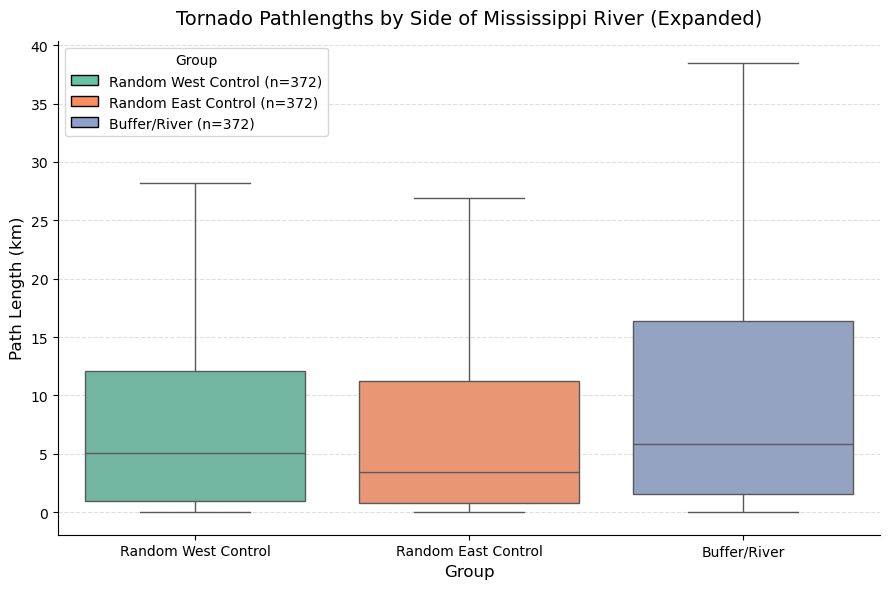


Five-number summary for tornado pathlengths (km):
                          Min        Q1    Median         Q3         Max
side_type                                                               
Buffer/River         0.000000  1.601293  5.825811  16.383081  237.216716
Random East Control  0.000000  0.804670  3.484221  11.265380  130.356540
Random West Control  0.016093  0.961581  5.061374  12.086143  186.683440


In [35]:
# --- Step 1: Prepare each subset for plotting ---

# West Control (random sample, 372 tornadoes)
west_plot = random_west_control[['len']].copy()
west_plot['side_type'] = "Random West Control"

# East Control (random sample, 372 tornadoes)
east_plot = random_east_control[['len']].copy()
east_plot['side_type'] = "Random East Control"

# Test population (Buffer + River intersections, 372 tornadoes)
test_plot = test_population[['len']].copy()
test_plot['side_type'] = "Buffer/River"

# --- Step 2: Convert pathlength from miles → kilometers ---
for df in [west_plot, east_plot, test_plot]:
    df['len'] = df['len'] * 1.60934  # mi → km

# --- Step 3: Combine all three categories ---
plot_df = pd.concat([west_plot, east_plot, test_plot], ignore_index=True)

print("Total tornadoes included in expanded box plot:", len(plot_df))  # should be 1116

# --- Step 4: Create boxplot ---
plt.figure(figsize=(9, 6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=plot_df,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False
)

# --- Step 5: Build custom legend with sample sizes ---
counts = plot_df["side_type"].value_counts()

legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{category} (n={counts[category]})")
    for i, category in enumerate(['Random West Control', 'Random East Control', 'Buffer/River'])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# --- Step 6: Final formatting ---
ax.set_title("Tornado Pathlengths by Side of Mississippi River (Expanded)", 
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 7: Compute five-number summaries for each group ---
summary_stats = (
    plot_df.groupby("side_type")['len']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary for tornado pathlengths (km):")
print(summary_stats)

In [36]:
# -----------------------------------------------------------
# Kruskal-Wallis test for RANDOM subsampled groups (372 each)
# -----------------------------------------------------------

import itertools
from scipy.stats import kruskal

# Group data from the random-sampled plot_df
groups_rand = plot_df.groupby('side_type')['len'].apply(list)

# Extract lists
west_len   = groups_rand['Random West Control']
east_len   = groups_rand['Random East Control']
buffer_len = groups_rand['Buffer/River']

# --- 1. Overall Kruskal-Wallis test ---
stat, p = kruskal(west_len, east_len, buffer_len)

print(f"Overall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# --- 2. Pairwise Kruskal-Wallis tests ---
pairs = list(itertools.combinations(groups_rand.index, 2))
results = []

for a, b in pairs:
    stat_ab, p_ab = kruskal(groups_rand[a], groups_rand[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': stat_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)

print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal-Wallis test: H = 14.952, p = 0.0006

Pairwise Kruskal-Wallis results:
                Group1               Group2          H   p-value Significant?
0         Buffer/River  Random East Control  14.396484  0.000148          Yes
1         Buffer/River  Random West Control   5.636778  0.017587          Yes
2  Random East Control  Random West Control   2.389495  0.122153           No


### Kruskal-Wallis Test on Tornado Path Lengths  
#### Random Subsampled Groups (372 Tornadoes per Group)

**Overall Test:**
- **Kruskal–Wallis H = 14.952**, **p = 0.0006**
- **Interpretation:** There is a statistically significant difference in tornado path lengths among the three groups (Random West Control, Random East Control, Buffer/River).

**Pairwise Comparisons:**

| Group 1              | Group 2              | H        | p-value     | Significant? |
|----------------------|----------------------|----------|-------------|--------------|
| Buffer/River         | Random East Control  | 14.396   | 0.000148    | Yes          |
| Buffer/River         | Random West Control  | 5.637    | 0.017587    | Yes          |
| Random East Control  | Random West Control  | 2.389    | 0.122153    | No           |

**Summary:**
- Tornadoes in the **Buffer/River** interaction zone have significantly different path lengths compared to **both random control groups**.
- The two random control groups (**East vs. West**) **do not differ significantly** from each other.

Total tornadoes in width plot: 5793


/tmp/ipykernel_979/2631839374.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




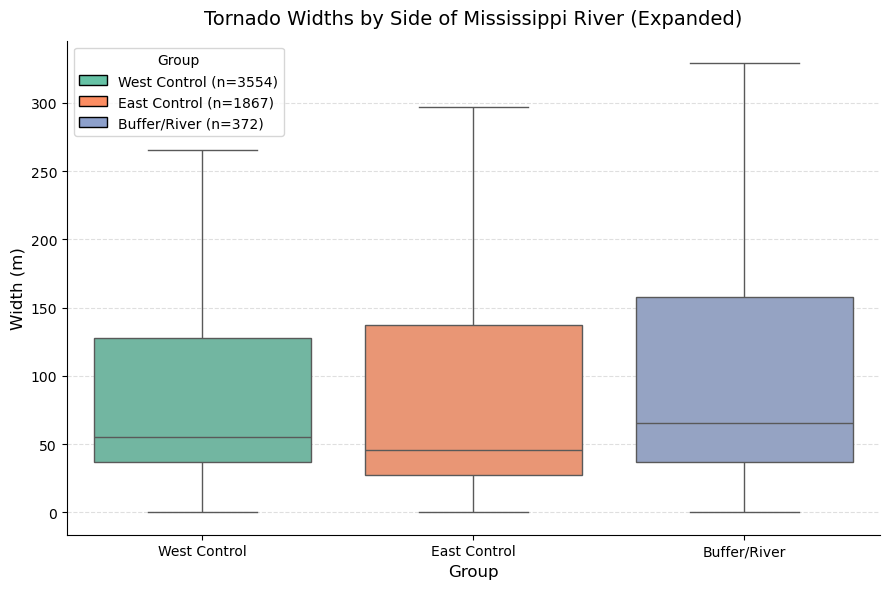


Five-number summary for tornado widths (m):

              Min      Q1   Median        Q3       Max
side_type                                             
Buffer/River  0.0  36.576  65.3796  157.9626  2011.680
East Control  0.0  27.432  45.7200  137.1600  2404.872
West Control  0.0  36.576  54.8640  128.0160  2414.016


In [37]:
# -----------------------------------------------------------
# Boxplot of Tornado Width by Side of Mississippi River
# Using ORIGINAL full West/East control populations
# -----------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# --- Step 1: Prepare each dataset ---

# Original West Control population
orig_west_width = west_control[['wid']].copy()
orig_west_width['width_m'] = orig_west_width['wid'] * 0.9144  # yards → meters
orig_west_width['side_type'] = "West Control"

# Original East Control population
orig_east_width = east_control[['wid']].copy()
orig_east_width['width_m'] = orig_east_width['wid'] * 0.9144  # yards → meters
orig_east_width['side_type'] = "East Control"

# Buffer/River Test population (unchanged)
test_width_full = test_population[['wid']].copy()
test_width_full['width_m'] = test_width_full['wid'] * 0.9144  # yards → meters
test_width_full['side_type'] = "Buffer/River"

# Combine datasets
width_plot_full = pd.concat(
    [orig_west_width, orig_east_width, test_width_full],
    ignore_index=True
)

print("Total tornadoes in width plot:", len(width_plot_full))

# --- Step 2: Create boxplot ---
plt.figure(figsize=(9,6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=width_plot_full,
    x="side_type",
    y="width_m",
    palette=palette,
    showfliers=False
)

# --- Step 3: Legend with counts ---
counts_full = width_plot_full['side_type'].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts_full[cat]})")
    for i, cat in enumerate(['West Control', 'East Control', 'Buffer/River'])
]

ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    title="Group",
    frameon=True
)

# --- Step 4: Formatting ---
ax.set_title("Tornado Widths by Side of Mississippi River (Expanded)", fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 5: Five-number summary ---
width_summary_full = (
    width_plot_full.groupby("side_type")['width_m']
    .describe(percentiles=[0.25,0.5,0.75])
    [['min','25%','50%','75%','max']]
)

width_summary_full.columns = ['Min','Q1','Median','Q3','Max']

print("\nFive-number summary for tornado widths (m):\n")
print(width_summary_full)

In [38]:
# -----------------------------------------------------------
# Kruskal–Wallis tests for ORIGINAL full populations (widths)
# -----------------------------------------------------------

# Group widths into lists
groups_full_width = width_plot_full.groupby("side_type")['width_m'].apply(list)

west_full = groups_full_width['West Control']
east_full = groups_full_width['East Control']
buffer_full = groups_full_width['Buffer/River']

# --- Overall Kruskal–Wallis test ---
H_full, p_full = kruskal(west_full, east_full, buffer_full)

print(f"Overall Kruskal–Wallis test: H = {H_full:.3f}, p = {p_full:.6f}\n")

# --- Pairwise comparisons ---
pairs = list(itertools.combinations(groups_full_width.index, 2))
pairwise_results_full = []

for g1, g2 in pairs:
    H, p = kruskal(groups_full_width[g1], groups_full_width[g2])
    pairwise_results_full.append({
        "Group1": g1,
        "Group2": g2,
        "H": H,
        "p-value": p,
        "Significant?": "Yes" if p < 0.05 else "No"
    })

pairwise_full_df = pd.DataFrame(pairwise_results_full)

print("Pairwise Kruskal–Wallis results:")
print(pairwise_full_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal–Wallis test: H = 12.368, p = 0.002062

Pairwise Kruskal–Wallis results:
         Group1        Group2         H   p-value Significant?
0  Buffer/River  East Control  7.766269  0.005323          Yes
1  Buffer/River  West Control  2.695922  0.100605           No
2  East Control  West Control  8.067640  0.004506          Yes


### Kruskal-Wallis Test on Tornado Widths (Full Populations)

**Overall Test:**
- Kruskal-Wallis H = 12.368 , p = 0.002062
- Interpretation: Statistically significant differences exist among at least two of the three groups (p < 0.05).

**Pairwise Comparisons:**

| Group 1       | Group 2      | H        | p-value   | Significant? |
|---------------|--------------|----------|-----------|--------------|
| West Control  | East Control | 8.067640 | 0.004506  | Yes          |
| West Control  | Buffer/River | 2.695922 | 0.100605  | No           |
| East Control  | Buffer/River | 7.766269 | 0.005323  | Yes          |

**Summary:**
- East Control tornado widths differ significantly from both West Control and Buffer/River.
- West Control and Buffer/River do **not** differ significantly.
- The strongest separation is between East Control vs. both other groups.


Total tornadoes in width plot: 1116


/tmp/ipykernel_979/254205482.py:37: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




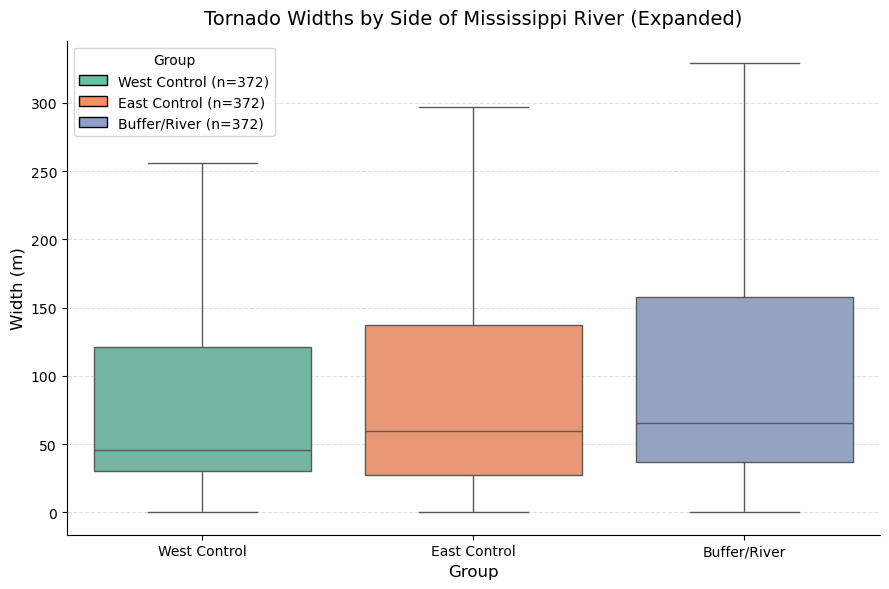


Five-number summary for tornado widths (m):

              Min       Q1   Median        Q3       Max
side_type                                              
Buffer/River  0.0  36.5760  65.3796  157.9626  2011.680
East Control  0.0  27.4320  59.4360  137.1600  2404.872
West Control  0.0  30.1752  45.7200  121.1580  2414.016


In [39]:
# -----------------------------------------------------------
# Boxplot of Tornado Width by Side of Mississippi River
# Expanded sample: West Control, East Control, Buffer/River
# -----------------------------------------------------------

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

# --- Step 1: Prepare each dataset ---

# West Control (372 tornadoes)
west_width = random_west_control[['wid']].copy()
west_width['width_m'] = west_width['wid'] * 0.9144   # yards → meters
west_width['side_type'] = "West Control"

# East Control (372 tornadoes)
east_width = random_east_control[['wid']].copy()
east_width['width_m'] = east_width['wid'] * 0.9144   # yards → meters
east_width['side_type'] = "East Control"

# Buffer + River Test population (372 tornadoes)
test_width = test_population[['wid']].copy()
test_width['width_m'] = test_width['wid'] * 0.9144   # yards → meters
test_width['side_type'] = "Buffer/River"

# Combine into one DataFrame
width_plot_df = pd.concat([west_width, east_width, test_width], ignore_index=True)

print("Total tornadoes in width plot:", len(width_plot_df))  # Expected: 1116

# --- Step 2: Create boxplot ---
plt.figure(figsize=(9,6))
palette = sns.color_palette("Set2", 3)

ax = sns.boxplot(
    data=width_plot_df,
    x="side_type",
    y="width_m",
    palette=palette,
    showfliers=False
)

# --- Step 3: Legend with counts ---
counts = width_plot_df["side_type"].value_counts()
legend_elements = [
    Patch(facecolor=palette[i], edgecolor='black',
          label=f"{cat} (n={counts[cat]})")
    for i, cat in enumerate(['West Control', 'East Control', 'Buffer/River'])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# --- Step 4: Formatting ---
ax.set_title("Tornado Widths by Side of Mississippi River (Expanded)", fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# --- Step 5: Five-number summary statistics ---
width_summary = (
    width_plot_df.groupby("side_type")['width_m']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

width_summary.columns = ['Min','Q1','Median','Q3','Max']

print("\nFive-number summary for tornado widths (m):\n")
print(width_summary)

In [40]:
# -----------------------------------------------------------
# Kruskal–Wallis tests for RANDOM 372-sample populations
# -----------------------------------------------------------

# Group widths into lists
groups_rand_width = width_plot_df.groupby("side_type")['width_m'].apply(list)

west_rand = groups_rand_width['West Control']
east_rand = groups_rand_width['East Control']
buffer_rand = groups_rand_width['Buffer/River']

# --- Overall Kruskal–Wallis test ---
H_rand, p_rand = kruskal(west_rand, east_rand, buffer_rand)

print(f"Overall Kruskal–Wallis test: H = {H_rand:.3f}, p = {p_rand:.6f}\n")

# --- Pairwise comparisons ---
pairs = list(itertools.combinations(groups_rand_width.index, 2))
pairwise_results_rand = []

for g1, g2 in pairs:
    H, p = kruskal(groups_rand_width[g1], groups_rand_width[g2])
    pairwise_results_rand.append({
        "Group1": g1,
        "Group2": g2,
        "H": H,
        "p-value": p,
        "Significant?": "Yes" if p < 0.05 else "No"
    })

pairwise_rand_df = pd.DataFrame(pairwise_results_rand)

print("Pairwise Kruskal–Wallis results:")
print(pairwise_rand_df)

#Evaluated at the 0.05 significance level.

Overall Kruskal–Wallis test: H = 3.915, p = 0.141212

Pairwise Kruskal–Wallis results:
         Group1        Group2         H   p-value Significant?
0  Buffer/River  East Control  3.096677  0.078452           No
1  Buffer/River  West Control  2.678638  0.101703           No
2  East Control  West Control  0.113008  0.736745           No


### Kruskal-Wallis Test on Tornado Widths (Random 372-Sample Populations)

**Overall Test:**
- Kruskal-Wallis H = 3.915 , p = 0.141212
- Interpretation: No statistically significant differences were found among the three randomly sampled groups (p > 0.05).

**Pairwise Comparisons:**

| Group 1               | Group 2               | H        | p-value   | Significant? |
|-----------------------|-----------------------|----------|-----------|--------------|
| Random West Control   | Random East Control   | 0.113008 | 0.736745  | No           |
| Random West Control   | Buffer/River          | 2.678638 | 0.101703  | No           |
| Random East Control   | Buffer/River          | 3.096677 | 0.078452  | No           |

**Summary:**
- None of the pairwise comparisons are statistically significant after random sampling.
- Differences observed in the full population disappear when sample sizes are equalized (n = 372 each).

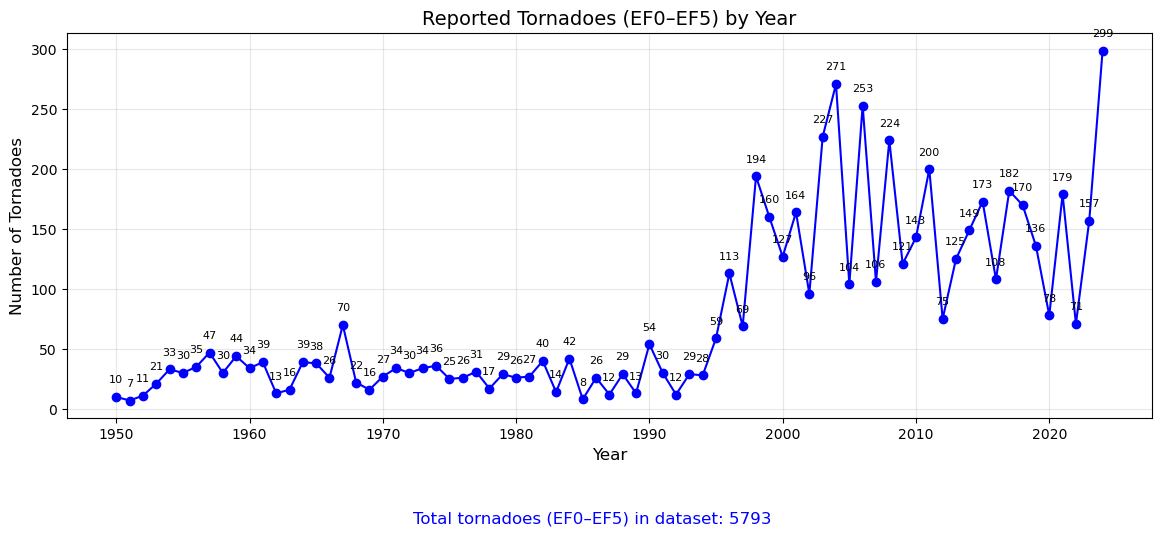

In [41]:
# Extract year from tornado dates
weak_tornadoes["year"] = weak_tornadoes["date"].dt.year

# Group by year
yearly_counts = weak_tornadoes.groupby("year").size()

# Plot timeline
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(yearly_counts.index, yearly_counts.values, marker='o', color='blue', linewidth=1.5)

# Annotate counts above each point
for x, y in zip(yearly_counts.index, yearly_counts.values):
    ax.text(x, y + 10, str(y), ha='center', va='bottom', fontsize=8)

ax.set_title("Reported Tornadoes (EF0–EF5) by Year", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Tornadoes", fontsize=12)
ax.grid(alpha=0.3)

# Add total sum below the plot
total_weak = len(weak_tornadoes)
plt.figtext(0.5, -0.1, f"Total tornadoes (EF0–EF5) in dataset: {total_weak}", 
            ha='center', fontsize=12, color='blue')

plt.show()

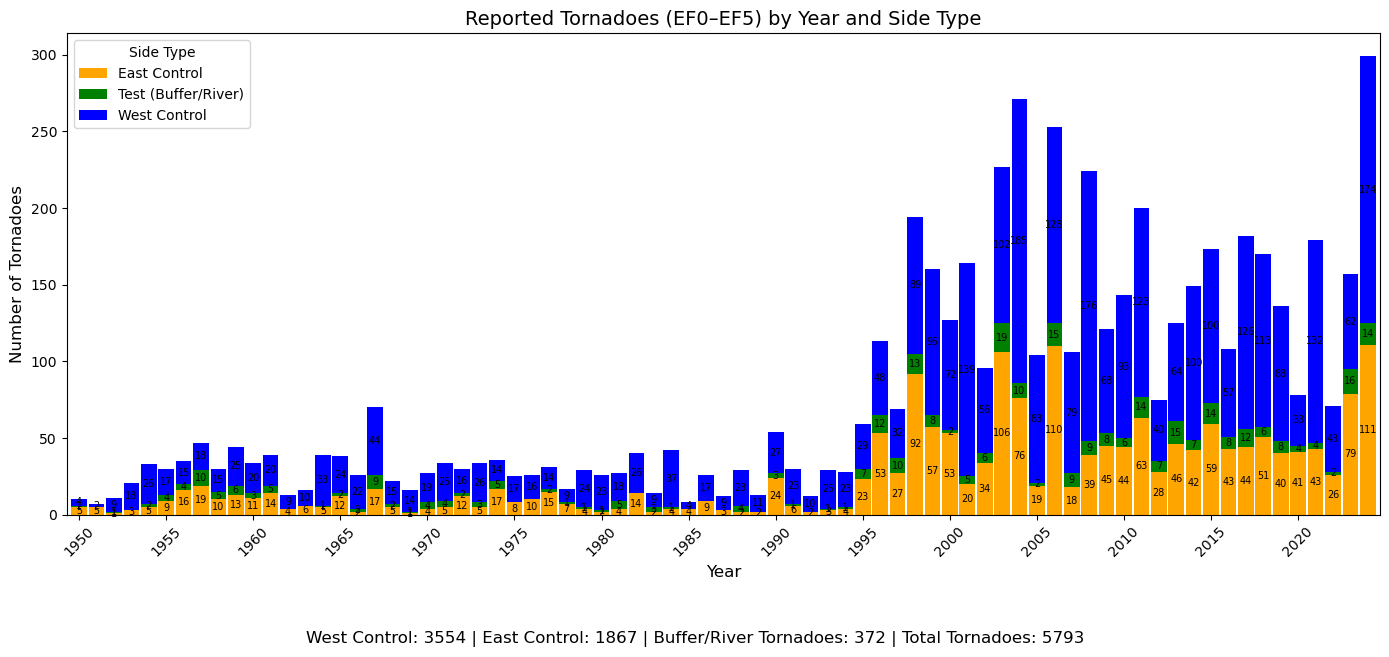

In [42]:
# Group by year and side_type
yearly_side_counts = weak_tornadoes.groupby(["year", "side_type"]).size().unstack(fill_value=0)

# Plot stacked bar chart with wider bars
fig, ax = plt.subplots(figsize=(14, 6))
yearly_side_counts.plot(
    kind='bar',
    stacked=True,
    ax=ax,
    color=['orange', 'green', 'blue'],
    width=0.9  # wider bars
)

# Annotate counts on each segment (black text)
for i, year in enumerate(yearly_side_counts.index):
    bottom = 0
    for side in yearly_side_counts.columns:
        count = yearly_side_counts.loc[year, side]
        if count > 0:
            ax.text(i, bottom + count / 2, str(count), ha='center', va='center', fontsize=7, color='black')
            bottom += count

ax.set_title("Reported Tornadoes (EF0–EF5) by Year and Side Type", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Number of Tornadoes", fontsize=12)
ax.legend(title="Side Type")

# X-axis ticks every 5 years
years = yearly_side_counts.index
ax.set_xticks([i for i, y in enumerate(years) if y % 5 == 0])
ax.set_xticklabels([y for y in years if y % 5 == 0], rotation=45)

plt.tight_layout()

# Add summed counts below the plot
west_total = len(west_control)
east_total = len(east_control)
test_total = len(test_population)
total_weak = len(weak_tornadoes)
sum_text = (f"West Control: {west_total} | East Control: {east_total} | "
            f"Buffer/River Tornadoes: {test_total} | Total Tornadoes: {total_weak}")
plt.figtext(0.5, -0.08, sum_text, ha='center', fontsize=12, color='black')

plt.show()

In [43]:
# Ensure we start with tornadoes only
weak_tornadoes = tornado_gdf[tornado_gdf["mag"].isin([0, 1, 2, 3, 4, 5])].copy()

# Filter to only tornadoes that intersect the river or the 10 km buffer
crossing_tornadoes = weak_tornadoes[weak_tornadoes.intersects(river_il_geom)].copy()
buffer_only = weak_tornadoes[
    weak_tornadoes.intersects(river_buffer) &
    (~weak_tornadoes.intersects(river_il_geom))
].copy()

# Compute centroids for buffer_only
buffer_only["centroid"] = buffer_only.geometry.centroid

# Use river center x to split buffer_only
river_center_x = river_il_geom.centroid.x
west_side = buffer_only[buffer_only["centroid"].x < river_center_x].copy()
east_side = buffer_only[buffer_only["centroid"].x >= river_center_x].copy()

# Combine all three groups — this should now be exactly 325
river_buffer_tornadoes = pd.concat([west_side, east_side, crossing_tornadoes])
print("Check total tornadoes (should be 372):", len(river_buffer_tornadoes))

print("West-side total (within/touching 10 km buffer, not touching river):", len(west_side))
print("East-side total (within/touching 10 km buffer, not touching river):", len(east_side))
print("Crossing/touching river total:", len(crossing_tornadoes))
print("Sum check:", len(west_side) + len(east_side) + len(crossing_tornadoes))

Check total tornadoes (should be 372): 372
West-side total (within/touching 10 km buffer, not touching river): 120
East-side total (within/touching 10 km buffer, not touching river): 163
Crossing/touching river total: 89
Sum check: 372


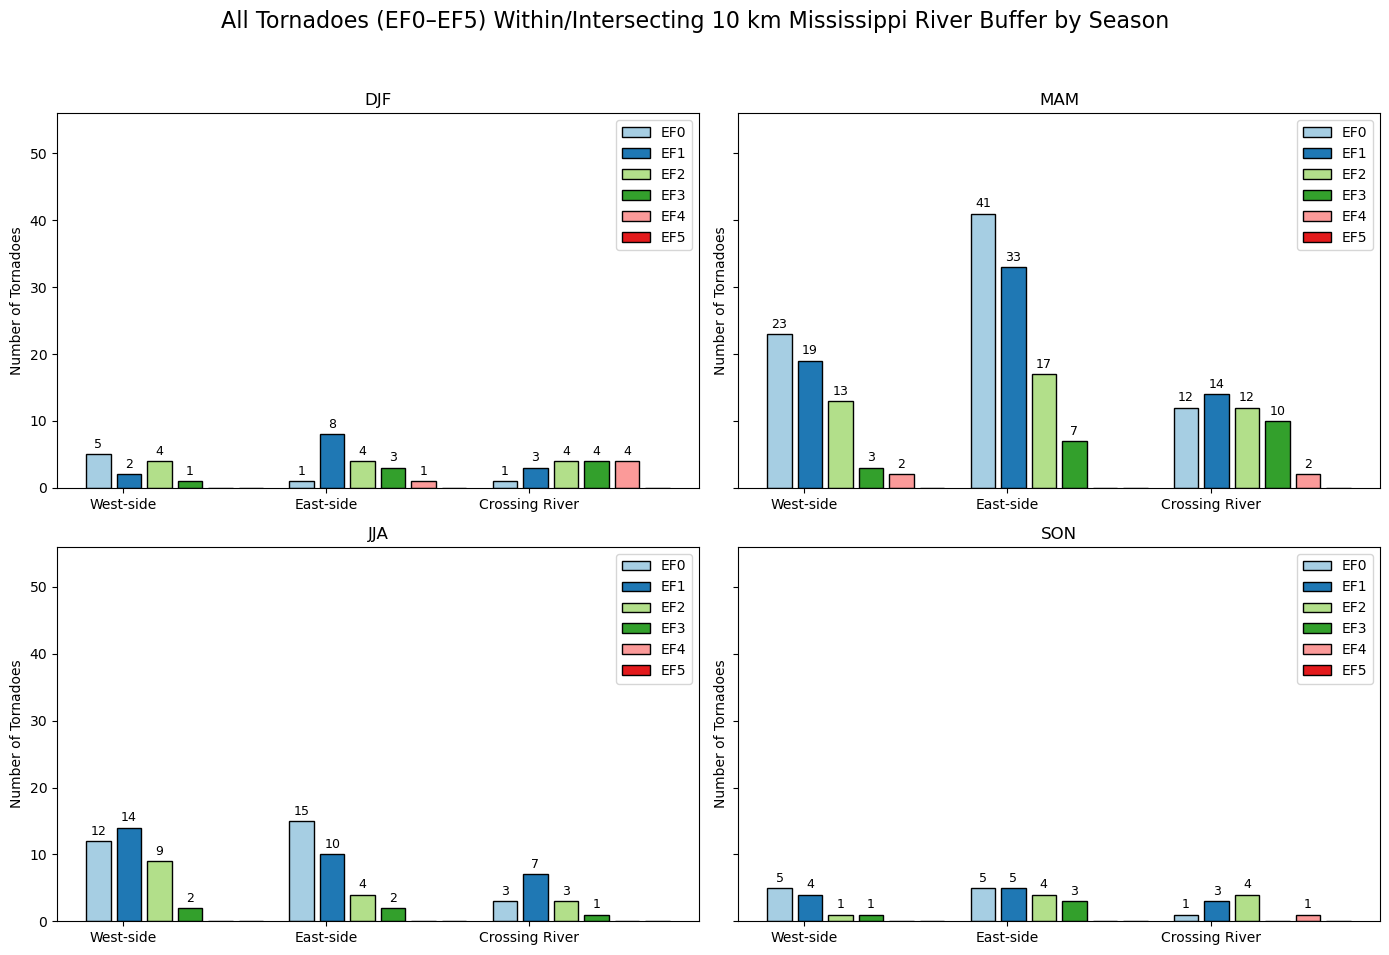

Totals by side_type across all seasons (should sum to 372): 372
side_type
East-side         163
West-side         120
Crossing River     89
Name: count, dtype: int64


In [44]:
# --- Ensure seasonal grouping ---
# Define a function to map month to meteorological season
def get_season(month):
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    else:
        return "SON"

# Filter to only river buffer tornadoes (372)
river_buffer_tornadoes = pd.concat([west_side, east_side, crossing_tornadoes])
river_buffer_tornadoes = river_buffer_tornadoes.copy()

# Assign side_type if not already
river_buffer_tornadoes.loc[river_buffer_tornadoes.index.isin(west_side.index), "side_type"] = "West-side"
river_buffer_tornadoes.loc[river_buffer_tornadoes.index.isin(east_side.index), "side_type"] = "East-side"
river_buffer_tornadoes.loc[river_buffer_tornadoes.index.isin(crossing_tornadoes.index), "side_type"] = "Crossing River"

# Assign season
river_buffer_tornadoes["season"] = river_buffer_tornadoes["date"].dt.month.apply(get_season)

# --- Prepare plotting data ---
plot_data = river_buffer_tornadoes.groupby(["season", "side_type", "mag"]).size().reset_index(name="count")

# Define order
seasons = ["DJF", "MAM", "JJA", "SON"]
sides = ["West-side", "East-side", "Crossing River"]
ef_order = [0, 1, 2, 3, 4, 5]
colors = {0: "#a6cee3", 1: "#1f78b4", 2: "#b2df8a", 3: "#33a02c", 4: "#fb9a99", 5: "#e31a1c"}  # EF0, EF1, EF2, EF3, EF4, EF5

# --- 2x2 subplot setup ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    season_data = plot_data[plot_data["season"] == season]

    # Width and positions
    bar_width = 0.12
    spacing_factor = 1.25

    x = np.arange(len(sides))

    # Plot EF0, EF1, EF2, EF3, EF4, EF5 stacked for each side
    for j, ef in enumerate(ef_order):
        ef_counts = []
        for side in sides:
            val = season_data[(season_data["side_type"] == side) & (season_data["mag"] == ef)]["count"]
            ef_counts.append(val.values[0] if not val.empty else 0)
        
        bottom = None
        if j == 0:
            bottom = np.zeros(len(sides))
        else:
            bottom = np.array([
                season_data[(season_data["side_type"] == side) & (season_data["mag"] < ef)]["count"].sum()
                for side in sides
            ])
        bars = ax.bar(x + j*bar_width*spacing_factor, ef_counts, width=bar_width, color=colors[ef], label=f"EF{ef}", edgecolor='k')
        
        # Add counts above bars
        for rect, count in zip(bars, ef_counts):
            if count > 0:
                ax.text(rect.get_x() + rect.get_width()/2, rect.get_height() + rect.get_y() + 0.5,
                        int(count), ha='center', va='bottom', fontsize=9, color='black')

    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(sides)
    ax.set_title(f"{season}", fontsize=12)
    ax.set_ylabel("Number of Tornadoes")
    ax.set_ylim(0, max(plot_data["count"])+15)
    ax.legend()

plt.suptitle("All Tornadoes (EF0–EF5) Within/Intersecting 10 km Mississippi River Buffer by Season", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Print summed counts for verification ---
print("Totals by side_type across all seasons (should sum to 372):", river_buffer_tornadoes["side_type"].value_counts().sum())
print(river_buffer_tornadoes["side_type"].value_counts())

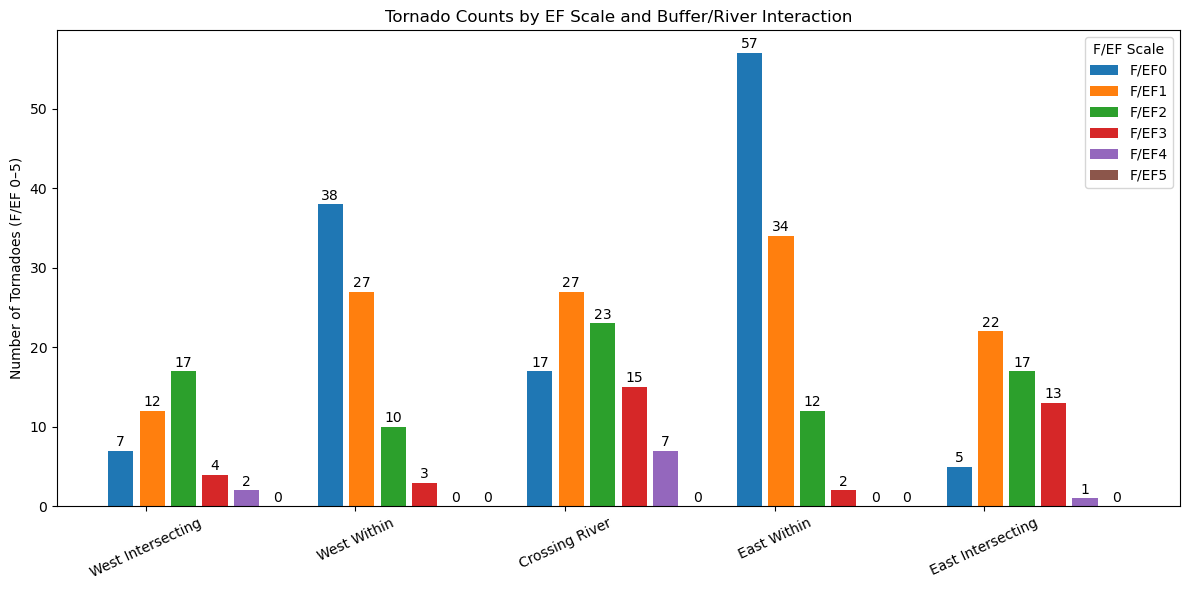

In [45]:
import matplotlib.pyplot as plt

# --- Step 1: Define helper to classify "completely within" vs "intersecting" ---
def completely_within(geom, buffer_geom):
    if geom.geom_type == "Point":
        return buffer_geom.contains(geom)
    elif geom.geom_type == "LineString":
        # Get boundary points as a list
        pts = list(geom.boundary.geoms)
        return buffer_geom.contains(pts[0]) and buffer_geom.contains(pts[1])
    return False

# --- Step 2: Separate the west and east tornadoes into intersecting vs completely within ---
west_intersecting = west_side[~west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

east_intersecting = east_side[~east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]

# crossing already exists
crossing = crossing_tornadoes.copy()

# --- Step 3: Compute EF-scale counts for each bin ---
bins = {
    "West Intersecting": west_intersecting,
    "West Within": west_within,
    "Crossing River": crossing,
    "East Within": east_within,
    "East Intersecting": east_intersecting
}

ef_counts = {k: v['mag'].value_counts().reindex([0,1,2,3,4,5], fill_value=0) for k,v in bins.items()}

# Convert to DataFrame for plotting
ef_df = pd.DataFrame(ef_counts).T  # rows=bins, columns=EF scale
ef_df.index.name = 'Bin'
ef_df.columns = ['F/EF0', 'F/EF1', 'F/EF2', 'F/EF3', 'F/EF4', 'F/EF5']

# --- Step 4: Plot clustered bar chart ---
fig, ax = plt.subplots(figsize=(12,6))

bar_width = 0.12
spacing_factor = 1.25
x = np.arange(len(ef_df))  # 5 clusters

# Store bar containers for labeling
bars = []
for i, ef in enumerate(ef_df.columns):
    b = ax.bar(x + i*bar_width*spacing_factor, ef_df[ef], width=bar_width, label=ef)
    bars.append(b)

# --- Add data labels on top of bars ---
for bar_group in bars:
    for bar in bar_group:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,  # center of the bar
            height + 0.2,                     # slightly above the bar
            f'{int(height)}',                 # convert to integer if counts
            ha='center', va='bottom', fontsize=10
        )

ax.set_xticks(x + bar_width)
ax.set_xticklabels(ef_df.index, rotation=25)
ax.set_ylabel("Number of Tornadoes (F/EF 0–5)")
ax.set_title("Tornado Counts by EF Scale and Buffer/River Interaction")
ax.legend(title="F/EF Scale")
plt.tight_layout()
plt.show()

Total tornadoes in 5-box boxplot: 620


/tmp/ipykernel_979/2632322301.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




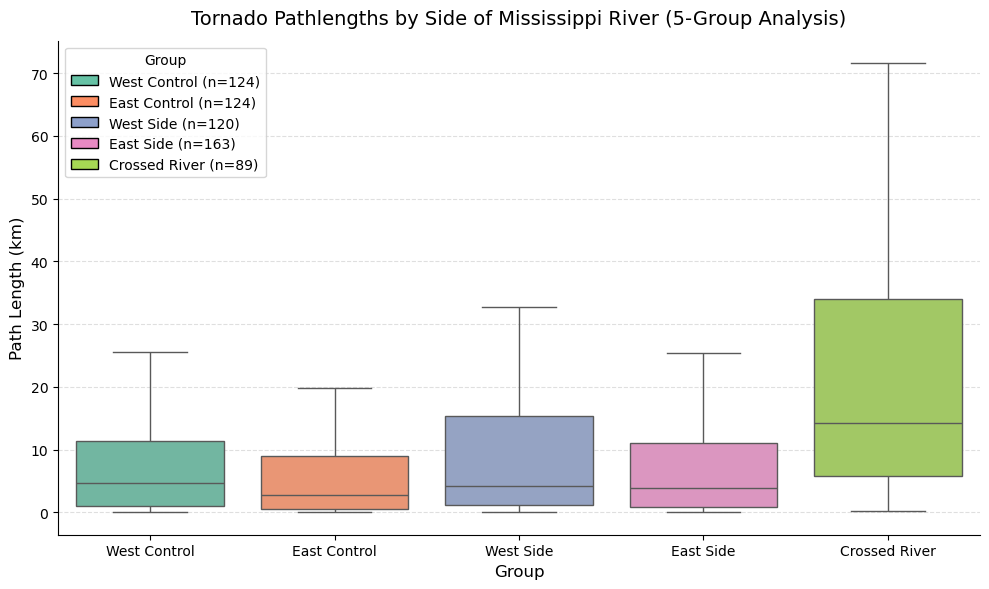


Five-number summary (km) for all 5 groups:
                    Min        Q1     Median         Q3         Max
side_type                                                          
Crossed River  0.160934  5.857998  14.162192  33.957074  237.216716
East Control   0.096560  0.506942   2.719785   8.968047   62.764260
East Side      0.032187  0.804670   3.878509  11.015932  122.148906
West Control   0.080467  0.925370   4.667086  11.309637   61.154920
West Side      0.000000  1.118491   4.200377  15.365174  147.254610


In [46]:
# ==========================================================
# --- Step 1: Prepare DataFrames for plotting ---
# ==========================================================

# --- Randomly sample West/East Control to n=124 ---
west_control_sampled = west_control.sample(n=124, replace=False, random_state=42)
east_control_sampled = east_control.sample(n=124, replace=False, random_state=42)

# West Control
west_control_plot = west_control_sampled[['len']].copy()
west_control_plot['side_type'] = "West Control"

# East Control
east_control_plot = east_control_sampled[['len']].copy()
east_control_plot['side_type'] = "East Control"

# West Side
west_side_plot = west_side[['len']].copy()
west_side_plot['side_type'] = "West Side"

# East Side
east_side_plot = east_side[['len']].copy()
east_side_plot['side_type'] = "East Side"

# Crossing River
cross_plot = crossing_tornadoes[['len']].copy()
cross_plot['side_type'] = "Crossed River"

# ==========================================================
# --- Step 2: Convert pathlength miles → kilometers ---
# ==========================================================

for df in [west_control_plot, east_control_plot, west_side_plot, east_side_plot, cross_plot]:
    df['len'] = df['len'] * 1.60934

# ==========================================================
# --- Step 3: Combine datasets ---
# ==========================================================

plot_df_full = pd.concat([
    west_control_plot,
    east_control_plot,
    west_side_plot,
    east_side_plot,
    cross_plot
], ignore_index=True)

print("Total tornadoes in 5-box boxplot:", len(plot_df_full))

# ==========================================================
# --- Step 4: Create boxplot ---
# ==========================================================

plt.figure(figsize=(10, 6))
palette = sns.color_palette("Set2", 5)

ax = sns.boxplot(
    data=plot_df_full,
    x="side_type",
    y="len",
    palette=palette,
    showfliers=False
)

# ==========================================================
# --- Step 5: Legend with actual sample sizes ---
# ==========================================================

counts_full = plot_df_full["side_type"].value_counts()

legend_elements = [
    Patch(
        facecolor=palette[i],
        edgecolor='black',
        label=f"{category} (n={counts_full[category]})"
    )
    for i, category in enumerate([
        "West Control",
        "East Control",
        "West Side",
        "East Side",
        "Crossed River"
    ])
]

ax.legend(handles=legend_elements,
          loc='upper left',
          fontsize=10,
          title="Group",
          frameon=True)

# ==========================================================
# --- Step 6: Formatting ---
# ==========================================================

ax.set_title("Tornado Pathlengths by Side of Mississippi River (5-Group Analysis)", 
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Path Length (km)", fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# ==========================================================
# --- Step 7: Five-number summary ---
# ==========================================================

summary_stats_full = (
    plot_df_full.groupby("side_type")['len']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats_full.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary (km) for all 5 groups:")
print(summary_stats_full)


In [47]:
# ==========================================================
# --- Step 8: Kruskal–Wallis tests ---
# ==========================================================

groups_full = plot_df_full.groupby('side_type')['len'].apply(list)

# Extract lists for clarity
west_control_len = groups_full['West Control']
east_control_len = groups_full['East Control']
west_side_len = groups_full['West Side']
east_side_len = groups_full['East Side']
cross_len = groups_full['Crossed River']

# --- 1. Overall Kruskal-Wallis test ---
stat, p = kruskal(west_control_len, east_control_len,
                  west_side_len, east_side_len, cross_len)

print(f"\nOverall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# --- 2. Pairwise tests ---
pairs = list(itertools.combinations(groups_full.index, 2))
results = []

for a, b in pairs:
    stat_ab, p_ab = kruskal(groups_full[a], groups_full[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': stat_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

# Evaluated at the 0.05 significance level.


Overall Kruskal-Wallis test: H = 58.531, p = 0.0000

Pairwise Kruskal-Wallis results:
          Group1        Group2          H       p-value Significant?
0  Crossed River  East Control  48.441154  3.403502e-12          Yes
1  Crossed River     East Side  38.999485  4.239175e-10          Yes
2  Crossed River  West Control  38.609374  5.176970e-10          Yes
3  Crossed River     West Side  27.384670  1.667479e-07          Yes
4   East Control     East Side   2.636863  1.044095e-01           No
5   East Control  West Control   1.591620  2.070948e-01           No
6   East Control     West Side   3.299733  6.929114e-02           No
7      East Side  West Control   0.031204  8.597861e-01           No
8      East Side     West Side   0.159294  6.898077e-01           No
9   West Control     West Side   0.432943  5.105484e-01           No


### Kruskal–Wallis Test on Tornado Path Lengths (km) — All Tornadoes (EF0–EF5)

**Overall Test:**
- **Kruskal–Wallis H = 58.531**, **p = 0.0000**
- **Interpretation:** There is a **highly significant overall difference** in tornado path lengths among the five groups.

**Pairwise Comparisons:**

| Group 1       | Group 2       | H        | p-value        | Significant? |
|---------------|---------------|----------|----------------|--------------|
| Crossed River | East Control  | 48.4412  | 3.40×10⁻¹²      | Yes          |
| Crossed River | East Side     | 38.9995  | 4.24×10⁻¹⁰      | Yes          |
| Crossed River | West Control  | 38.6094  | 5.18×10⁻¹⁰      | Yes          |
| Crossed River | West Side     | 27.3847  | 1.67×10⁻⁰⁷      | Yes          |
| East Control  | East Side     | 2.6369   | 0.10441        | No           |
| East Control  | West Control  | 1.5916   | 0.20709        | No           |
| East Control  | West Side     | 3.2997   | 0.06929        | No           |
| East Side     | West Control  | 0.0312   | 0.85979        | No           |
| East Side     | West Side     | 0.1593   | 0.68981        | No           |
| West Control  | West Side     | 0.4329   | 0.51055        | No           |

**Summary:**
- The **Crossed River** group differs significantly from **all four** other groups.
- The four non-crossing groups (**East Control**, **West Control**, **East Side**, **West Side**) show **no significant differences** among each other.
- These results indicate that **cross-river tornadoes systematically have longer path lengths**, even when including strong tornadoes (EF2–EF5), suggesting the pattern is robust across the full intensity spectrum.

**Conclusion:**  
Using all tornado intensities greatly strengthens the statistical signal. **Cross-river tornadoes exhibit markedly longer paths** than all other groups, while the remaining categories remain statistically similar to one another.

Total tornadoes included: 620
side_type
East Side        163
West Control     124
East Control     124
West Side        120
Crossed River     89
Name: count, dtype: int64


/tmp/ipykernel_979/4288810480.py:59: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




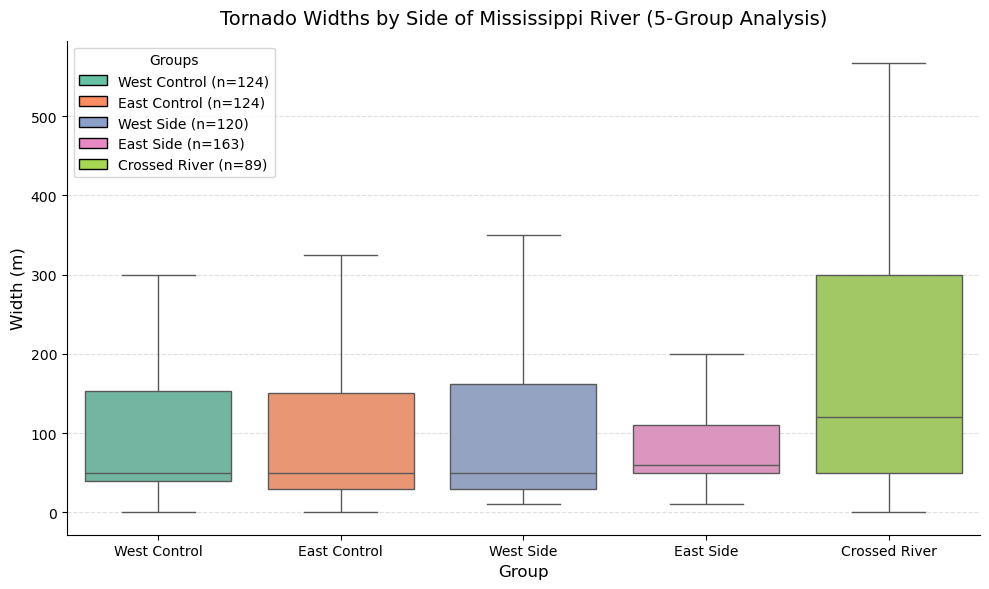


Five-number summary (m) for all 5 groups:
                Min    Q1  Median     Q3     Max
side_type                                       
Crossed River   0.0  50.0   120.0  300.0  2200.0
East Control    0.0  30.0    50.0  150.0   880.0
East Side      10.0  50.0    60.0  110.0  1760.0
West Control    0.0  40.0    50.0  152.5  2600.0
West Side      10.0  30.0    50.0  162.5  1000.0


In [49]:
# -------------------------------------------------------
# Step 1 — Prepare DataFrames (width in meters)
# -------------------------------------------------------

# West Control (random sample n = 124)
west_width = west_control[['wid']].copy()
west_width['side_type'] = "West Control"
west_width_sample = west_width.sample(n=124, random_state=42)

# East Control (random sample n = 124)
east_width = east_control[['wid']].copy()
east_width['side_type'] = "East Control"
east_width_sample = east_width.sample(n=124, random_state=42)

# West Side (n = 120)
west_side_width = west_side[['wid']].copy()
west_side_width['side_type'] = "West Side"

# East Side (n = 163)
east_side_width = east_side[['wid']].copy()
east_side_width['side_type'] = "East Side"

# Crossing River (n = 89)
cross_width = crossing_tornadoes[['wid']].copy()
cross_width['side_type'] = "Crossed River"

# -------------------------------------------------------
# Step 2 — Combine into a single plotting DataFrame
# -------------------------------------------------------

width_df = pd.concat([
    west_width_sample,
    east_width_sample,
    west_side_width,
    east_side_width,
    cross_width
], ignore_index=True)

print("Total tornadoes included:", len(width_df))
print(width_df['side_type'].value_counts())

# -------------------------------------------------------
# Step 3 — Create Box Plot for Width (m)
# -------------------------------------------------------

plt.figure(figsize=(10, 6))

# Define consistent ordering for groups
category_order = [
    "West Control",
    "East Control",
    "West Side",
    "East Side",
    "Crossed River"
]

palette = sns.color_palette("Set2", len(category_order))

ax = sns.boxplot(
    data=width_df,
    x="side_type",
    y="wid",
    order=category_order,        # <--- enforce ordering
    palette=palette,
    showfliers=False
)

# Legend with correct colors
counts = width_df["side_type"].value_counts()

legend_elements = [
    Patch(
        facecolor=palette[i],
        edgecolor='black',
        label=f"{category} (n={counts[category]})"
    )
    for i, category in enumerate(category_order)
]

ax.legend(
    handles=legend_elements,
    loc='upper left',
    fontsize=10,
    title="Groups",
    frameon=True
)

ax.set_title("Tornado Widths by Side of Mississippi River (5-Group Analysis)",
             fontsize=14, pad=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Width (m)", fontsize=12)

ax.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine()
plt.tight_layout()
plt.show()

# ==========================================================
# --- Step 4: Five-number summary ---
# ==========================================================

summary_stats_full = (
    width_df.groupby("side_type")['wid']
    .describe(percentiles=[0.25, 0.5, 0.75])
    [['min','25%','50%','75%','max']]
)

summary_stats_full.columns = ['Min', 'Q1', 'Median', 'Q3', 'Max']

print("\nFive-number summary (m) for all 5 groups:")
print(summary_stats_full)

In [50]:
# -------------------------------------------------------
# Step 5 — Kruskal–Wallis Test (All Five Groups)
# -------------------------------------------------------
groups = width_df.groupby('side_type')['wid'].apply(list)

# Extract lists for KW
group_lists = [groups[g] for g in groups.index]

stat, p = kruskal(*group_lists)

print(f"\nOverall Kruskal-Wallis test: H = {stat:.3f}, p = {p:.4f}")

# -------------------------------------------------------
# Step 6 — Pairwise Kruskal–Wallis Tests
# -------------------------------------------------------
pairs = list(itertools.combinations(groups.index, 2))
results = []

for a, b in pairs:
    h_ab, p_ab = kruskal(groups[a], groups[b])
    results.append({
        'Group1': a,
        'Group2': b,
        'H': h_ab,
        'p-value': p_ab,
        'Significant?': "Yes" if p_ab < 0.05 else "No"
    })

pairwise_df = pd.DataFrame(results)
print("\nPairwise Kruskal-Wallis results:")
print(pairwise_df)

# Evaluated at the 0.05 significance level.


Overall Kruskal-Wallis test: H = 20.800, p = 0.0003

Pairwise Kruskal-Wallis results:
          Group1        Group2          H   p-value Significant?
0  Crossed River  East Control  14.067554  0.000176          Yes
1  Crossed River     East Side  14.988780  0.000108          Yes
2  Crossed River  West Control  11.343386  0.000757          Yes
3  Crossed River     West Side  14.019422  0.000181          Yes
4   East Control     East Side   0.168914  0.681079           No
5   East Control  West Control   0.120035  0.728997           No
6   East Control     West Side   0.359908  0.548557           No
7      East Side  West Control   0.024689  0.875144           No
8      East Side     West Side   1.486631  0.222740           No
9   West Control     West Side   0.920588  0.337321           No


### Kruskal–Wallis Test on Tornado Widths (m) — All Tornadoes (EF0–EF5)

**Overall Test:**
- **Kruskal–Wallis H = 20.800**, **p = 0.0003**
- **Interpretation:** There is a **statistically significant overall difference** in tornado widths among the five groups.

**Pairwise Comparisons:**

| Group 1       | Group 2       | H        | p-value    | Significant? |
|---------------|---------------|----------|------------|--------------|
| Crossed River | East Control  | 14.0676  | 0.000176   | Yes          |
| Crossed River | East Side     | 14.9888  | 0.000108   | Yes          |
| Crossed River | West Control  | 11.3434  | 0.000757   | Yes          |
| Crossed River | West Side     | 14.0194  | 0.000181   | Yes          |
| East Control  | East Side     | 0.1689   | 0.68108    | No           |
| East Control  | West Control  | 0.1200   | 0.728997   | No           |
| East Control  | West Side     | 0.3599   | 0.54856    | No           |
| East Side     | West Control  | 0.0247   | 0.87514    | No           |
| East Side     | West Side     | 1.4866   | 0.22274    | No           |
| West Control  | West Side     | 0.9206   | 0.33732    | No           |

**Summary:**
- The **Crossed River** group differs significantly from **all four** other groups.
- No significant differences exist among the four non-crossing groups (**East Control**, **West Control**, **East Side**, **West Side**).
- These results indicate that **cross-river tornadoes tend to have wider damage paths**, even when including strong tornadoes (EF2–EF5).

**Conclusion:**  
Across all tornado intensities, **cross-river tornadoes consistently display significantly greater widths** than all other categories, while the remaining groups remain statistically indistinguishable from one another. This reinforces the robustness of the cross-river effect when examining tornado width.

In [199]:
# --- Step 0: Ensure tornado_gdf is loaded and river_il_geom exists ---
target_crs = "EPSG:26915"  # UTM Zone 15
tornado_gdf = tornado_gdf.to_crs(target_crs)
river_gs = gpd.GeoSeries([river_il_geom], crs=target_crs)
river_il_geom = river_gs.iloc[0]

# --- Helper functions ---
def start_point(geom):
    return Point(geom.coords[0]) if geom.geom_type == 'LineString' else geom

def end_point(geom):
    return Point(geom.coords[-1]) if geom.geom_type == 'LineString' else geom

def get_season(month):
    if month in [12,1,2]: return 'DJF'
    if month in [3,4,5]: return 'MAM'
    if month in [6,7,8]: return 'JJA'
    return 'SON'

# Distance with sign relative to river centerline
def signed_distance_km(point, river_geom):
    nearest_pt = nearest_points(point, river_geom)[1]
    dist = point.distance(nearest_pt) / 1000  # meters -> km
    # Assign negative if west of river centroid
    return -dist if point.x < river_geom.centroid.x else dist

# --- Step 1: Start/end points and season ---
tornado_gdf['start_pt'] = tornado_gdf['geometry'].apply(start_point)
tornado_gdf['end_pt'] = tornado_gdf['geometry'].apply(end_point)
tornado_gdf['season'] = tornado_gdf['date'].dt.month.apply(get_season)


In [200]:
# --- Step 2: Classify tornadoes ---
river_buffer = river_il_geom.buffer(10000)  # 10 km buffer
river_center_x = river_il_geom.centroid.x

def classify_side(row):
    if row['geometry'].intersects(river_il_geom):
        return 'Crossed River'
    centroid_x = row['geometry'].centroid.x
    if centroid_x < river_center_x and row['geometry'].intersects(river_buffer):
        return 'West-side'
    elif centroid_x >= river_center_x and row['geometry'].intersects(river_buffer):
        return 'East-side'
    return None

tornado_gdf['side_type'] = tornado_gdf.apply(classify_side, axis=1)

# --- Step 3: Compute signed distances ---
tornado_gdf['start_dist_km'] = tornado_gdf['start_pt'].apply(lambda p: signed_distance_km(p, river_il_geom))
tornado_gdf['end_dist_km'] = tornado_gdf['end_pt'].apply(lambda p: signed_distance_km(p, river_il_geom))

In [201]:
# --- Step 4: Build summary table ---
rows = ['Start West', 'Start Crossed', 'Start East', 'End West', 'End Crossed', 'End East']
cols = ['DJF','MAM','JJA','SON','Annual']

table = pd.DataFrame(index=rows, columns=cols)

for season in ['DJF','MAM','JJA','SON']:
    seasonal = tornado_gdf[tornado_gdf['season']==season]
    
    for side, row_prefix in zip(['West-side','Crossed River','East-side'],
                                ['West','Crossed','East']):
        # Start
        values = seasonal[seasonal['side_type']==side]['start_dist_km']
        table.loc[f'Start {row_prefix}', season] = round(values.mean(),2) if not values.empty else '--'
        # End
        values = seasonal[seasonal['side_type']==side]['end_dist_km']
        table.loc[f'End {row_prefix}', season] = round(values.mean(),2) if not values.empty else '--'

# Annual averages
for side, row_prefix in zip(['West-side','Crossed River','East-side'],
                            ['West','Crossed','East']):
    values = tornado_gdf[tornado_gdf['side_type']==side]['start_dist_km']
    table.loc[f'Start {row_prefix}','Annual'] = round(values.mean(),2) if not values.empty else '--'
    values = tornado_gdf[tornado_gdf['side_type']==side]['end_dist_km']
    table.loc[f'End {row_prefix}','Annual'] = round(values.mean(),2) if not values.empty else '--'

# Display
display(table)

,DJF,MAM,JJA,SON,Annual
Start West,-6.65,-8.22,-4.64,-6.38,-6.79
Start Crossed,-2.15,-2.84,-2.42,-11.29,-3.51
Start East,8.23,5.45,5.78,11.97,6.48
End West,-7.06,-4.13,-3.64,-5.98,-4.44
End Crossed,20.73,4.92,3.11,6.48,7.63
End East,9.5,8.55,5.54,10.53,8.28


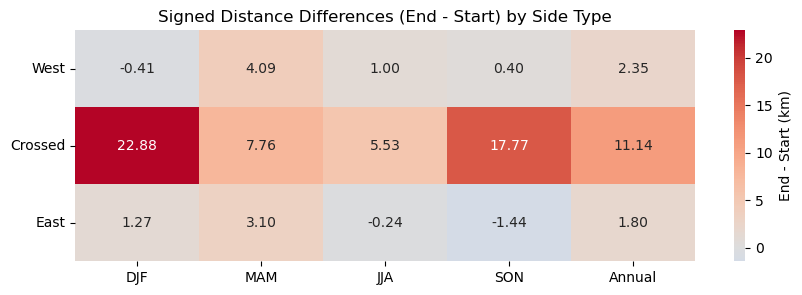

In [203]:
# --- Step 5: Compute differences (End - Start) per side type ---
diff_table = pd.DataFrame(index=['West','Crossed','East'], columns=cols)

for side_prefix in ['West','Crossed','East']:
    for col in cols:
        start_val = table.loc[f'Start {side_prefix}', col]
        end_val = table.loc[f'End {side_prefix}', col]
        if start_val == '--' or end_val == '--':
            diff_table.loc[side_prefix, col] = None
        else:
            diff_table.loc[side_prefix, col] = round(end_val - start_val, 2)

# --- Step 6: Display heatmap of differences ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 3))
sns.heatmap(diff_table.astype(float), annot=True, fmt=".2f",
            cmap="coolwarm", center=0, cbar_kws={'label': 'End - Start (km)'})
plt.title("Signed Distance Differences (End - Start) by Side Type")
plt.yticks(rotation=0)
plt.show()

In [202]:
# --- Count tornadoes by side type ---
counts = tornado_gdf['side_type'].value_counts()

print("Number of tornadoes per side type:")
print(f"West Side: {counts.get('West-side', 0)}")
print(f"Crossed River: {counts.get('Crossed River', 0)}")
print(f"East Side: {counts.get('East-side', 0)}")
print(f"Total tornadoes in table: {counts.sum()}")

Number of tornadoes per side type:
West Side: 120
Crossed River: 89
East Side: 163
Total tornadoes in table: 372


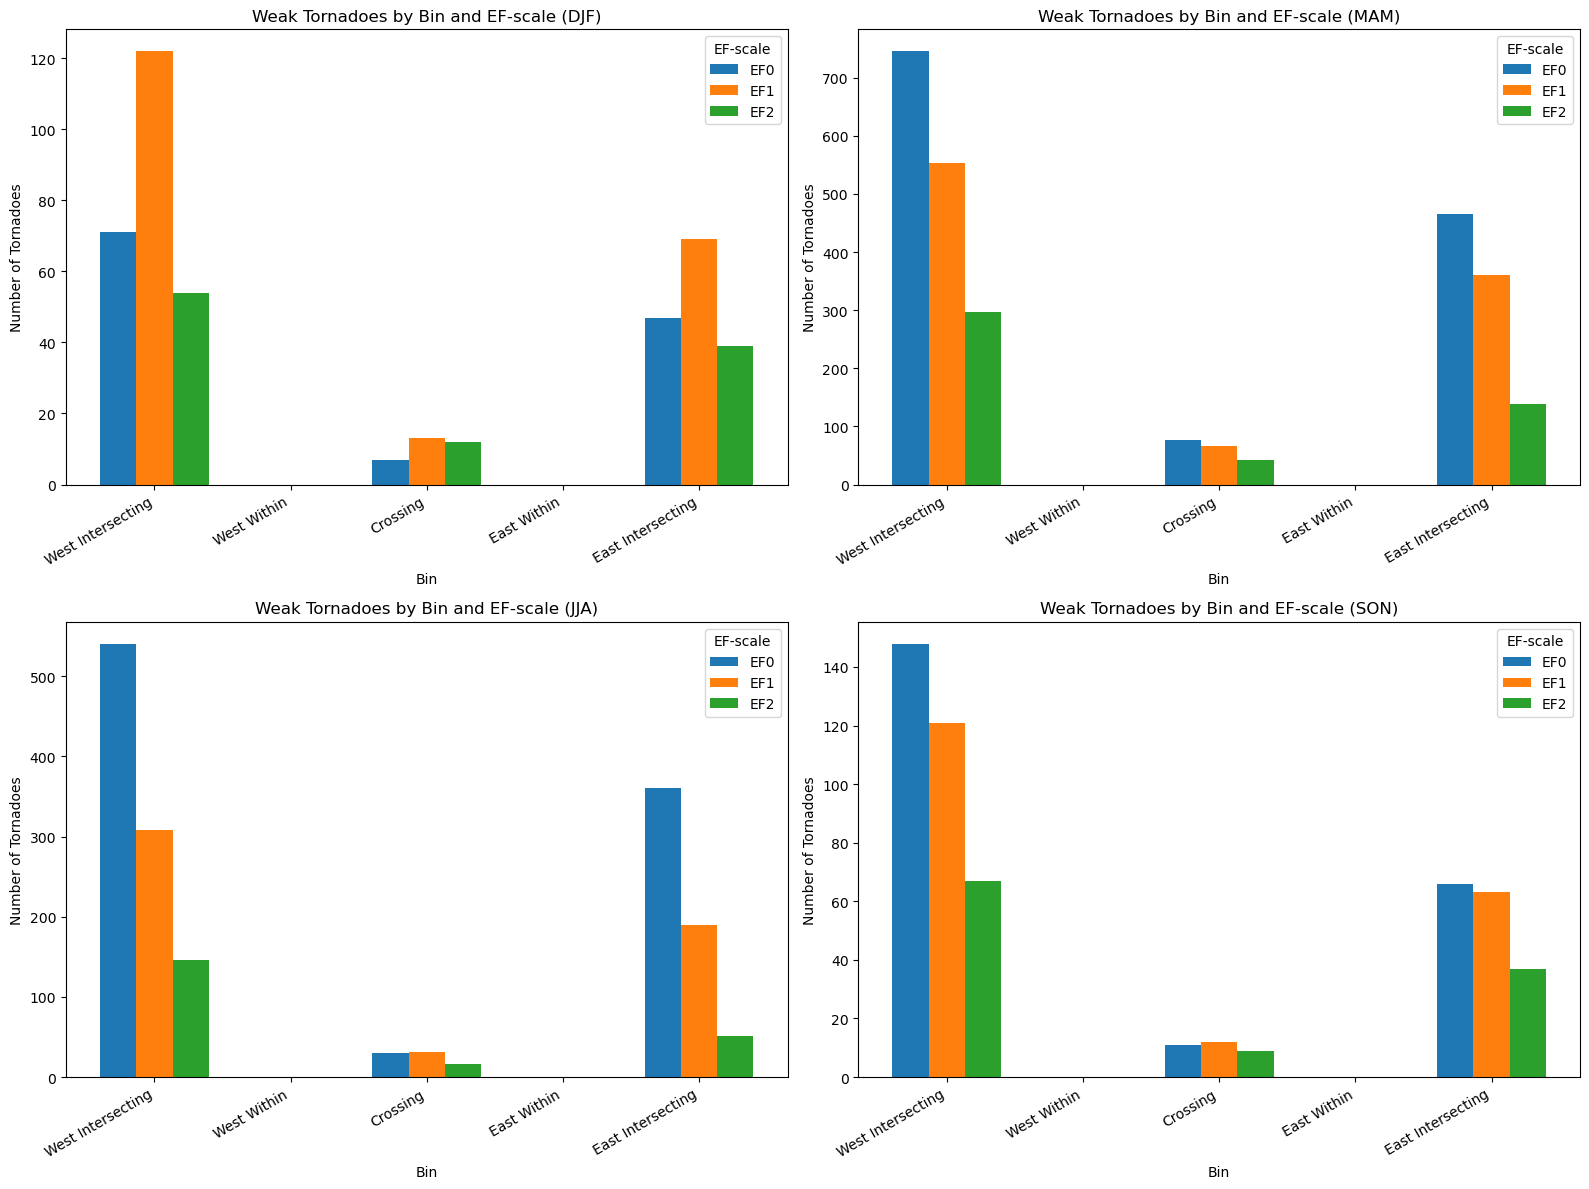

In [46]:
###############################
##Additional Work for Seasons##
###############################

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

# --- Step 0: Make sure seasonal column exists ---
tornado_gdf['month'] = tornado_gdf['date'].dt.month
def get_season(month):
    if month in [12, 1, 2]: return 'DJF'
    elif month in [3, 4, 5]: return 'MAM'
    elif month in [6, 7, 8]: return 'JJA'
    else: return 'SON'
tornado_gdf['season'] = tornado_gdf['month'].apply(get_season)

# --- Step 1: Define helper functions ---
def completely_within(geom, buffer_geom):
    """Returns True if both endpoints of a LineString are within buffer_geom, or if a Point is within."""
    from shapely.geometry import Point, LineString, MultiPoint

    if geom.geom_type == 'Point':
        return buffer_geom.contains(geom)
    elif geom.geom_type == 'LineString':
        # Extract boundary points safely
        b = geom.boundary
        if isinstance(b, Point):
            pts = [b]
        elif isinstance(b, MultiPoint):
            pts = list(b.geoms)
        else:
            pts = list(b)  # fallback
        return all(buffer_geom.contains(pt) for pt in pts)
    return False

# Step 2: Pre-compute bins for all tornadoes (so seasonal plots match all-season bins)
west_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x < river_il_geom.centroid.x))]
east_side = tornado_gdf[(tornado_gdf['crosses_river']==False) & (tornado_gdf['geometry'].apply(lambda g: g.centroid.x > river_il_geom.centroid.x))]
crossing = tornado_gdf[tornado_gdf['crosses_river']==True]

# Compute intersecting vs within for west and east
west_within = west_side[west_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
west_intersecting = west_side[~west_side.index.isin(west_within.index)]
east_within = east_side[east_side.apply(lambda r: completely_within(r.geometry, river_buffer), axis=1)]
east_intersecting = east_side[~east_side.index.isin(east_within.index)]

# --- Step 3: Prepare seasonal counts per bin per EF-scale ---
bins_dict = {
    'West Intersecting': west_intersecting,
    'West Within': west_within,
    'Crossing': crossing,
    'East Within': east_within,
    'East Intersecting': east_intersecting
}

seasons = ['DJF', 'MAM', 'JJA', 'SON']
ef_scales = [0, 1, 2]

# --- Step 4: Plot ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    counts = []
    for bin_name, gdf_bin in bins_dict.items():
        season_bin = gdf_bin[gdf_bin['season']==season]
        ef_counts = [season_bin[season_bin['mag']==ef].shape[0] for ef in ef_scales]
        counts.append(ef_counts)
    
    counts_df = pd.DataFrame(counts, index=bins_dict.keys(), columns=[f'EF{ef}' for ef in ef_scales])
    counts_df.plot(kind='bar', stacked=False, ax=ax, width=0.8)
    
    ax.set_title(f"Weak Tornadoes by Bin and EF-scale ({season})", fontsize=12)
    ax.set_ylabel("Number of Tornadoes")
    ax.set_xlabel("Bin")
    ax.legend(title="EF-scale")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.tight_layout()
plt.show()